In [2]:
import sys
sys.path.append('../../')
sys.path.append('../')

dataset_path = "../dataset"
preprocessed_dataset_path = "../dataset/preprocessed_dataset"

from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict

import re
%matplotlib inline

# batch2 genetics by Harriet

In [2]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [3]:
european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

In [4]:
PRS_imputed_Grove = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_nodups_euro_batch2_imputed.gwas.all_score',column_prefix='ASD_imputed_PRS_')
PRScs_imputed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRScs/asd/ASD_imputed.profile')
PRScs_imputed = PRScs_imputed.rename(columns={'SCORESUM':'ASD_imputed_CS'})
PRScs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRScs/asd/plink.profile')
PRScs = PRScs.rename(columns={'SCORESUM':'ASD_CS'})

ASD_LDpred = pd.concat([pd.read_csv(file,index_col=0,
                       skiprows=1,
                       names=['ASD_LDpred_'+file.split('_')[-1].replace('LDpred-','').replace('.txt','')] ) 
           for file in glob.glob('../../codes/gene_set/ldpred/output_asd/ASD_genotyped_score*')],axis=1)
ASD_LDpred = ASD_LDpred.reset_index().rename(columns={'index':'IID'})
ASD_LDpred['ID'] = ASD_LDpred['IID'].apply(lambda x: x.split('-')[0])
ASD_LDpred = ASD_LDpred.drop(columns=['IID'])

ASD_LDpred_imputed = pd.concat([pd.read_csv(file,index_col=0,
                       skiprows=1,
                       names=['ASD_imputed_LDpred_'+file.split('_')[-1].replace('LDpred-','').replace('.txt','')] ) 
           for file in glob.glob('../../codes/gene_set/ldpred/output_asd/ASD_imputed_score*')],axis=1)
ASD_LDpred_imputed = ASD_LDpred_imputed.reset_index().rename(columns={'index':'IID'})
ASD_LDpred_imputed['ID'] = ASD_LDpred_imputed['IID'].apply(lambda x: x.split('-')[0])
ASD_LDpred_imputed = ASD_LDpred_imputed.drop(columns=['IID'])

# ASD_LDpred_imputed.drop(columns='ASD_LDpred_imputed_p3.0000e-02',inplace=True)

In [5]:
european_volumetric_dataset_term = european_volumetric_dataset_term.merge(PRS_imputed_Grove,on='ID').merge(
    PRScs_imputed[['ID','ASD_imputed_CS']],on='ID').merge(PRScs[['ID','ASD_CS']],on='ID').merge(ASD_LDpred,on='ID').merge(
ASD_LDpred_imputed,on='ID')

`european_volumetric_dataset_term` has 279 observations (after removal of low image quality and radiology score)

In [7]:
# tract_volumes = pd.read_csv('../../codes/FBA/output/aba/wm_parcellation_volume.txt',delim_whitespace=True,header=None)
# tract_volumes = tract_volumes.iloc[:,np.r_[[0]+[i for i in range(94,148)]]]
#tract_volumes = pd.read_csv('../codes/FBA/output_ASD/aba/mean_log_jacob.txt',delim_whitespace=True,header=None)

In [8]:
# tract_volumes.columns = ['ID/Ses']+[f'wm_{i}_vol' for i in range(94,148)]
# tract_volumes = tract_volumes.drop_duplicates('ID/Ses')

In [6]:
available_dwi = pd.read_csv('../../codes/FBA/subject_lists/available_dwi.txt',header=None,names=['ID','Session'])
available_dwi['ID/Ses'] = available_dwi['ID']+'/'+available_dwi['Session'].astype('str')

In [7]:
def concat_files(files):
    to_return = pd.DataFrame()
    for variable,file in files.items():
        temp = pd.read_csv(file,delim_whitespace=True,header=None)
        temp.columns = ['ID/Ses']+[f'wm_{i}_{variable}' for i in range(94,148)]
        temp = temp.drop_duplicates('ID/Ses')
        temp['ID/Ses'] = temp['ID/Ses'].apply(lambda x: x.replace('_','/'))
        temp = temp.set_index('ID/Ses')
        to_return = pd.concat([to_return,temp],axis=1)
    return to_return.reset_index()

In [8]:
tract_metrics = concat_files({'fd':'../../codes/FBA/output_ASD/aba/mean_fd_not_smoothed_linear.txt',
                     'log_fc':'../../codes/FBA/output_ASD/aba/mean_log_fc_not_smoothed_linear.txt',
                     'fdc':'../../codes/FBA/output_ASD/aba/mean_fdc_not_smoothed_linear.txt'})

In [9]:
df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

# df = df.drop(columns='ASD_Spark_imputed_PRS_Pt_1e-07')

# pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
#     df,
#     dependentVar_cols=[i for i in df.columns if 'ASD_Spark_imputed_' in i],
#     scaling=True,
#     n_components=1
# )

# df['ASD_PRS_PC1'] = prs_pca

In [10]:
df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

In [11]:
# to_copy = df.merge(available_dwi,on=['ID/Ses'])[['ID/Ses','sex','GA','PMA','TBV']+[i for i in df.columns if 'ASD_Spark' in i]+ancestry]
# to_copy = df.merge(available_dwi,on=['ID/Ses'])[['ID/Ses','sex','GA','PMA','TBV']+[i for i in df.columns if 'ASD_Spark_imputed_PRS' in i]+['ASD_PRS_PC1','ASD_CS']+ancestry]
# to_copy = df.merge(available_dwi,on=['ID/Ses'])[['ID/Ses','sex','GA','PMA','TBV']+[i for i in df.columns if 'ASD_LDpred' in i]+ancestry]

In [12]:
# with open('../../codes/FBA/subject_lists/available_dwi_with_all_ASD_LDpred_imputed_after_ancestry_outliers.txt','w') as file:
#     file.write(' '.join(["#"] + to_copy.columns.tolist()) + '\n')
#     to_copy.to_csv(file,header=None,index=None)

In [13]:
# df.merge(available_subjects,on=['ID/Ses'])[['ID/Ses','sex','GA','PMA','TBV','ASD_PRS_Pt_0.01']+ancestry].to_csv('../codes/FBA/subject_lists/available_dwi_tbss.txt',index=False,header=None)

In [14]:
df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')

In [15]:
df = pd.merge(df,tract_metrics,on=['ID/Ses'],how='inner')

In [16]:
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_imputed_PRS' in i],
    scaling=True,
    n_components=1
)

df['PRS_imputed_pca'] = prs_pca

In [19]:
# tract_volumes[['ID/Ses','sex','GA','PMA','ASD_PRS_Pt_0.01','TBV']+ancestry].to_csv('../codes/FBA/subject_lists/available_dwi_with_PRS_after_ancestry_outliers.txt',header=None,index=False)

In [20]:
# tract_volumes[['ID/Ses','sex','GA','PMA','TBV']+[i for i in df.columns if 'ASD_PRS' in i]+ancestry].to_csv('../codes/FBA/subject_lists/available_dwi_with_all_PRS_after_ancestry_outliers.txt',header=None,index=False)

In [21]:
# group1, group2 = stats.Stability_tests.split_group(tract_volumes)

In [21]:
test_fdc = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=[i for i in df.columns if 'ASD_imputed_PRS' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in df.columns if 'wm_' in i and re.match(r'wm_\d+_fdc$',i)],scaling='both')

 ... (more hidden) ...


In [23]:
stats.MultipleCorrection.fdr(test_fdc,'PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,...,standardize(Q('euro_Anc_PC8'))_coef,standardize(Q('euro_Anc_PC8'))_pval,standardize(Q('euro_Anc_PC9'))_coef,standardize(Q('euro_Anc_PC9'))_pval,standardize(Q('euro_Anc_PC10'))_coef,standardize(Q('euro_Anc_PC10'))_pval,PRS_coef,PRS_pval,threshold,adjP
872,wm_102_log_fc,0.047090,0.274247,-0.093756,0.151418,0.077142,0.042986,0.001379,0.980549,0.898822,...,0.030584,0.345195,-0.022163,0.471138,0.033732,0.286595,0.119811,0.000050,ASD_imputed_PRS_Pt_0.01,0.040206
1034,wm_102_log_fc,0.042341,0.324376,-0.084300,0.195593,0.064791,0.086096,0.023097,0.680632,0.888014,...,0.028376,0.381120,-0.025988,0.398388,0.032552,0.302859,0.122782,0.000038,ASD_imputed_PRS_Pt_0.05,0.040206


In [22]:
test_fdc.to_csv('tract_based_mean_fdc_not_smoothed.csv',index=False)

In [23]:
test_fd = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=[i for i in df.columns if 'ASD_imputed_PRS' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA']+ancestry,
    dependentVar_cols=[i for i in df.columns if 'wm_' in i and re.match(r'wm_\d+_fd$',i)],scaling='both')

 ... (more hidden) ...


In [24]:
test_fd.to_csv('tract_based_mean_fd_not_smoothed.csv',index=False)

In [25]:
test_fc = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=[i for i in df.columns if 'ASD_imputed_PRS' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+[f'euro_Anc_PC{i}' for i in range(1,4)],
    dependentVar_cols=[i for i in df.columns if 'wm_' in i and re.match(r'wm_\d+_log_fc$',i)],scaling='both')

 ... (more hidden) ...


In [27]:
test_fc.sort_values(by='PRS_pval').to_csv('tract_based_mean_log_fc_not_smoothed.csv',index=False)

In [52]:
# test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
#     tract_volumes,
#     thresholds=[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['PRS_pca','ASD_CS'],
#     cat_independentVar_cols=['sex'],
#     cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
#     dependentVar_cols=[i for i in tract_volumes.columns if 'wm_' in i],scaling='both')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:34<00:00,  2.64s/it]


In [38]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
273,wm_97,0.044193,0.335780,-0.087987,0.202956,0.028264,0.487465,0.144202,0.017691,0.782200,5.513256e-35,0.022153,0.475054,0.017387,0.573242,-0.000770,0.980100,0.129722,0.000037,ASD_PRS_Pt_0.01
278,wm_102,0.018700,0.652683,-0.037232,0.551402,0.047022,0.202818,-0.114719,0.036939,0.987881,3.139969e-53,0.013066,0.641735,-0.003969,0.887087,0.015010,0.591692,0.098454,0.000511,ASD_PRS_Pt_0.01
279,wm_103,-0.031709,0.427805,0.063133,0.294114,0.039950,0.260428,-0.081510,0.122398,0.962496,4.988856e-54,-0.004816,0.858474,0.011958,0.656536,-0.008684,0.746923,0.090019,0.000941,ASD_PRS_Pt_0.01
272,wm_96,0.050065,0.316441,-0.099678,0.185165,-0.030900,0.485517,0.221565,0.000878,0.715523,1.987526e-27,0.028209,0.403434,-0.016522,0.622834,-0.052994,0.115949,0.104035,0.002171,ASD_PRS_Pt_0.01
317,wm_141,0.076138,0.240049,-0.151590,0.120326,0.057818,0.314319,0.176818,0.038919,0.629633,2.788790e-15,0.041812,0.339489,0.064768,0.137802,0.041195,0.344902,0.133663,0.002370,ASD_PRS_Pt_0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,wm_115,-0.083398,0.275361,0.166044,0.148702,0.045672,0.496081,-0.308699,0.002213,0.828237,3.377125e-18,0.024051,0.642051,0.038834,0.453295,-0.026803,0.603530,0.000632,0.990118,ASD_PRS_Pt_0.1
108,wm_94,-0.006906,0.901205,0.013750,0.870113,-0.004700,0.922666,-0.180712,0.012739,0.958618,4.885576e-36,0.047832,0.201662,-0.031933,0.391411,-0.005077,0.891233,-0.000394,0.991523,ASD_PRS_Pt_1e-05
234,wm_112,-0.039057,0.552348,0.077763,0.432472,0.026204,0.648617,0.062083,0.467587,0.714910,2.570175e-18,-0.024177,0.583906,-0.022314,0.612891,-0.019833,0.652441,-0.000451,0.991750,ASD_PRS_Pt_0.001
292,wm_116,-0.007567,0.843076,0.015066,0.793280,0.075413,0.027010,-0.101462,0.044815,0.974457,1.212040e-57,0.009429,0.715135,-0.015197,0.554706,0.019133,0.457548,-0.000242,0.992494,ASD_PRS_Pt_0.01


In [2]:
df = pd.read_csv('df_euro_fba.csv')

In [143]:
ancestry_list = [f'euro_Anc_PC{i}' for i in range(1,4)]
euro_summary_table = stats.MassUnivariate.print_summary_table(df,
                                                              thresholds = [i for i in df.columns if 'ASD_imputed_PRS_Pt' in i],
                                                              cat_independentVar_cols=['sex'],
                                                              cont_independentVar_cols =['GA','PMA','TBV']+ancestry_list,
                                                              dependentVar_cols=['wm_102_log_fc','wm_103_log_fc',
                                                                                'wm_96_log_fc','wm_144_log_fc'])

 ... (more hidden) ...


In [144]:
summary_table_ony_prs = euro_summary_table[[i for i in euro_summary_table.columns if 'ASD_imputed_PRS_Pt' in i]].sum(axis=1).reset_index()

In [145]:
summary_table_ony_prs.columns = ['Region','PRS_threshold','parameter','values']
summary_table_ony_prs['PRS_threshold'] = pd.Categorical(summary_table_ony_prs['PRS_threshold'],categories=summary_table_ony_prs['PRS_threshold'].unique(),ordered=True)

In [146]:
summary_table_ony_prs['PRS'] = summary_table_ony_prs['PRS_threshold'].apply(lambda x: '$%s$'%x.split('_')[4])

In [147]:
summary_table_ony_prs['PARAM'] = summary_table_ony_prs['parameter'].apply(lambda x: '$R^2$' if x == 'R2' else 'beta' if x=='Beta' else 'p-val')

In [136]:
# test = summary_table_ony_prs.copy()
# test['values_scientific'] = test['values'].apply(lambda x: "{:.2E}".format(x))

In [137]:
# test['values_scientific'] = test['values_scientific'].apply(lambda x: '$'+x.replace('E',' \cdot 10^{')+'}$')

In [138]:
# summary_table_ony_prs['values'] = summary_table_ony_prs['values'].apply(lambda x: "{:.5f}".format(x))

In [139]:
# summary_table_ony_prs.loc[summary_table_ony_prs['parameter']=='Beta','values'] = test.loc[test['parameter']=='Beta','values_scientific']

In [148]:
summary_table_only_prs_pivoted = summary_table_ony_prs.pivot(index=['Region','PARAM'],columns=['PRS'],values=['values'])

In [149]:
summary_table_only_prs_pivoted

values                                          \
PRS                   $1e-08$   $1e-06$   $1e-05$  $0.0001$   $0.001$   
Region        PARAM                                                     
wm_102_log_fc $R^2$  0.000196  0.000193  0.000152  0.000094  0.003956   
              beta  -0.001244 -0.001214 -0.001096  0.000860  0.005583   
              p-val  0.628290  0.631003  0.669576  0.737579  0.028651   
wm_103_log_fc $R^2$  0.000093  0.000234  0.000006  0.000468  0.004038   
              beta  -0.000889 -0.001388  0.000232  0.001994  0.005857   
              p-val  0.730555  0.584530  0.928296  0.438789  0.022213   
wm_144_log_fc $R^2$  0.007871  0.010151  0.005268  0.000196  0.006660   
              beta  -0.008087 -0.009033 -0.006615  0.001273  0.007424   
              p-val  0.041470  0.020413  0.095856  0.749019  0.060930   
wm_96_log_fc  $R^2$  0.001784  0.000044  0.000065  0.000113  0.001739   
              beta   0.004056  0.000625 -0.000774  0.001019  0.003998   
              p-val  0.231480  0.851635  0.819595  0.763743  0.237428   

                                                                       
PRS                    $0.01$    $0.05$     $0.1$     $0.5$       $1$  
Region        PARAM                                                    
wm_102_log_fc $R^2$  0.013072  0.012856  0.006908  0.006928  0.007321  
              beta   0.010178  0.009988  0.007361  0.007407  0.007625  
              p-val  0.000055  0.000064  0.003684  0.003635  0.002778  
wm_103_log_fc $R^2$  0.010609  0.006745  0.003846  0.003479  0.003738  
              beta   0.009523  0.007514  0.005704  0.005451  0.005658  
              p-val  0.000180  0.002996  0.025672  0.033932  0.027861  
wm_144_log_fc $R^2$  0.011380  0.004262  0.001731  0.004664  0.005034  
              beta   0.009734  0.005895  0.003777  0.006229  0.006481  
              p-val  0.014016  0.134412  0.340806  0.117273  0.103605  
wm_96_log_fc  $R^2$  0.008113  0.006328  0.004847  0.004853  0.005273  
              beta   0.008661  0.007569  0.006659  0.006696  0.006990  
              p-val  0.010239  0.023593  0.047900  0.047742  0.038986

In [152]:
print(summary_table_only_prs_pivoted.to_latex(float_format='%.5f'))

\begin{tabular}{llrrrrrrrrrr}
\toprule
 &  & \multicolumn{10}{r}{values} \\
 & PRS & $1e-08$ & $1e-06$ & $1e-05$ & $0.0001$ & $0.001$ & $0.01$ & $0.05$ & $0.1$ & $0.5$ & $1$ \\
Region & PARAM &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{wm_102_log_fc} & $R^2$ & 0.00020 & 0.00019 & 0.00015 & 0.00009 & 0.00396 & 0.01307 & 0.01286 & 0.00691 & 0.00693 & 0.00732 \\
 & beta & -0.00124 & -0.00121 & -0.00110 & 0.00086 & 0.00558 & 0.01018 & 0.00999 & 0.00736 & 0.00741 & 0.00762 \\
 & p-val & 0.62829 & 0.63100 & 0.66958 & 0.73758 & 0.02865 & 0.00006 & 0.00006 & 0.00368 & 0.00363 & 0.00278 \\
\cline{1-12}
\multirow[t]{3}{*}{wm_103_log_fc} & $R^2$ & 0.00009 & 0.00023 & 0.00001 & 0.00047 & 0.00404 & 0.01061 & 0.00675 & 0.00385 & 0.00348 & 0.00374 \\
 & beta & -0.00089 & -0.00139 & 0.00023 & 0.00199 & 0.00586 & 0.00952 & 0.00751 & 0.00570 & 0.00545 & 0.00566 \\
 & p-val & 0.73055 & 0.58453 & 0.92830 & 0.43879 & 0.02221 & 0.00018 & 0.00300 & 0.02567 & 0.03393 & 0.02786 \\
\cline{1-12}

In [24]:
test_fc = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=[i for i in df.columns if 'ASD_imputed_PRS' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+[f'euro_Anc_PC{i}' for i in range(1,4)],
    dependentVar_cols=[i for i in df.columns if 'wm_' in i and re.match(r'wm_\d+_log_fc$',i)],scaling='both')

 ... (more hidden) ...


In [34]:
data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()

{'wm_94': {'name': 'anterior limb of internal capsule left',
  'side': 'left',
  'segment': 'anterior',
  'structure': 'internal capsule',
  'abbr': 'IC.left.anterior'},
 'wm_95': {'name': 'anterior limb of internal capsule right',
  'side': 'right',
  'segment': 'anterior',
  'structure': 'internal capsule',
  'abbr': 'IC.right.anterior'},
 'wm_96': {'name': 'posterior limb of internal capsule left',
  'side': 'left',
  'segment': 'posterior',
  'structure': 'internal capsule',
  'abbr': 'IC.left.posterior'},
 'wm_97': {'name': 'posterior limb of internal capsule right',
  'side': 'right',
  'segment': 'posterior',
  'structure': 'internal capsule',
  'abbr': 'IC.right.posterior'},
 'wm_98': {'name': 'retrolenticular part of internal capsule left',
  'side': 'left',
  'segment': 'retrolenticular',
  'structure': 'internal capsule',
  'abbr': 'IC.left.retrolenticular'},
 'wm_99': {'name': 'retrolenticular part of internal capsule right',
  'side': 'right',
  'segment': 'retrolenticular

In [ ]:
103

In [66]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    tract_volumes,
    thresholds=[i for i in tract_volumes.columns if 'ASD_imputed_PRS_Pt' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in tract_volumes.columns if '_log_fc' in i],scaling='both')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.09s/it]


In [23]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(tract_volumes[[i for i in tract_volumes.columns if '_log_fc' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 26.428720934730936
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 14.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0035714285714285774


13.999999999999977

In [68]:
0.05/14/6/2

0.00029761904761904765

In [124]:
tract_log_fc_copy = tract_volumes.copy()

In [125]:
to_remove = [173,218,174]

In [126]:
tract_log_fc_copy = tract_log_fc_copy.iloc[[i for i in tract_log_fc_copy.index if i not in to_remove],:]

In [127]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(
    tract_log_fc_copy,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['ASD_imputed_PRS_Pt_0.01','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[f'wm_{i}_log_fc' for i in range(94,148)])

In [128]:
mass_univariate.sort_

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('ASD_imputed_PRS_Pt_0.01'))_coef,standardize(Q('ASD_imputed_PRS_Pt_0.01'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
wm_94_log_fc,0.056416,5.946196e-22,0.002468,0.754442,0.000465,0.894126,-0.001884,0.683363,-0.009736,1.598721e-01,0.087791,7.884283e-34,0.004549,0.197682,-0.005230,0.138070,0.002001,0.570851
wm_95_log_fc,0.051027,2.579009e-20,-0.002293,0.760210,0.001989,0.550288,0.000024,0.995565,-0.019499,3.361199e-03,0.092653,8.255329e-39,-0.000480,0.886195,-0.001519,0.650185,-0.004070,0.226661
wm_96_log_fc,0.046342,7.159455e-17,-0.010804,0.161795,0.007762,0.023757,0.004390,0.330857,0.041016,5.457952e-09,0.044180,1.425240e-12,0.001130,0.742738,-0.000638,0.852555,-0.002040,0.553950
wm_97_log_fc,0.048437,5.613141e-19,-0.007863,0.292445,0.005713,0.084835,0.007300,0.095645,0.038421,1.538762e-08,0.045792,5.444606e-14,0.001534,0.645409,-0.000031,0.992635,0.000055,0.986906
wm_98_log_fc,0.021114,1.863733e-07,-0.004833,0.414994,-0.000974,0.710595,0.000506,0.883990,0.022028,3.212874e-05,0.056933,1.483808e-27,-0.001588,0.548722,0.001894,0.473435,0.001845,0.486472
wm_99_log_fc,0.026040,8.233772e-11,-0.008416,0.144664,0.000531,0.834952,0.002253,0.503899,0.018466,3.100118e-04,0.059187,2.436423e-30,-0.001970,0.443786,0.001973,0.442179,0.000282,0.912850
wm_100_log_fc,-0.000883,8.894787e-01,0.016901,0.079413,-0.001690,0.691040,0.002503,0.656091,-0.067652,5.938494e-14,0.107256,5.057918e-34,0.004781,0.265541,-0.000516,0.904032,0.004945,0.250145
wm_101_log_fc,-0.008109,2.057631e-01,0.015664,0.106259,0.000194,0.963949,0.004412,0.435957,-0.072394,2.439848e-15,0.109335,1.374732e-34,0.000176,0.967492,0.002438,0.571716,-0.002197,0.611486
wm_102_log_fc,0.033845,1.171177e-17,-0.009251,0.091466,0.008199,0.000827,0.008820,0.006268,0.003842,4.223608e-01,0.073924,1.025849e-43,0.000712,0.770382,-0.000460,0.850120,-0.000193,0.937115
wm_103_log_fc,0.028101,7.671967e-13,-0.003127,0.574356,0.007436,0.002840,0.008582,0.008984,0.008216,9.299168e-02,0.073837,1.223247e-42,-0.000456,0.854577,0.000304,0.902356,-0.000771,0.756839


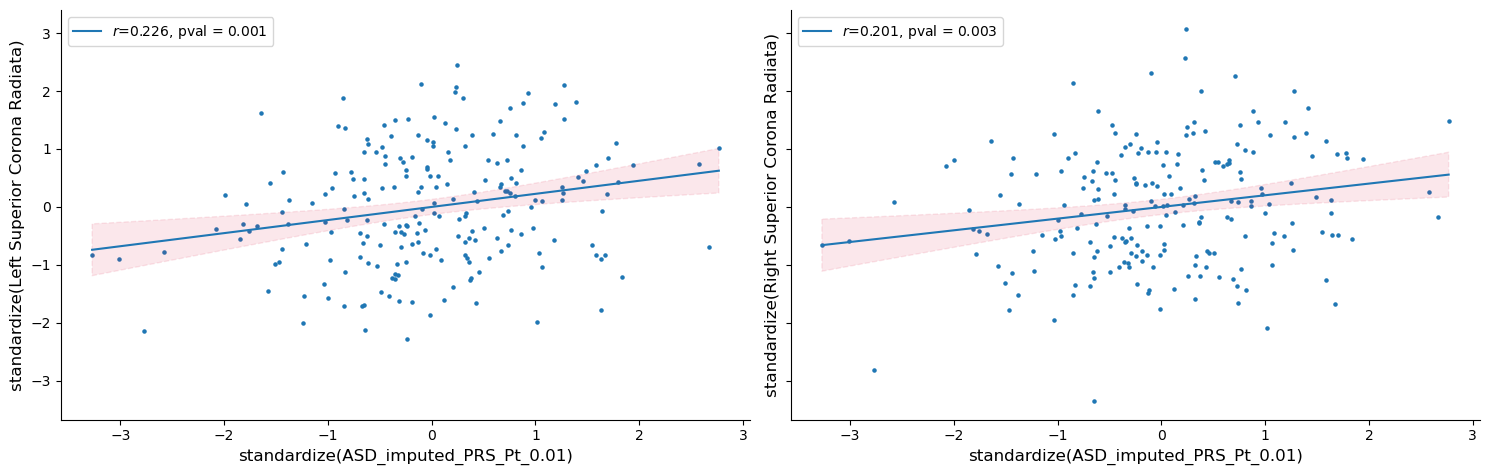

In [62]:
fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
visualisation.SimplePlots.Scatter(y=['wm_102_log_fc','wm_103_log_fc'],x=['ASD_imputed_PRS_Pt_0.01'],
                                  data=tract_log_fc_copy,
                                 adjust_covar={'y':['GA','PMA','TBV','sex'],
                                              'x':ancestry},
                                  legend_loc='upper left',
                                  scaling='both',figsize=(15,8),
                                  ax=ax,fig=fig,
                                 ylabel=['Left Superior Corona Radiata','Right Superior Corona Radiata'],
                                 markersize=5,fontsize=12)
sns.despine()
ax[0].set_xlabel('standardize(ASD_imputed_PRS_Pt_0.01)',fontsize=12)
plt.tight_layout()
fig.savefig('scatter_plot.png')

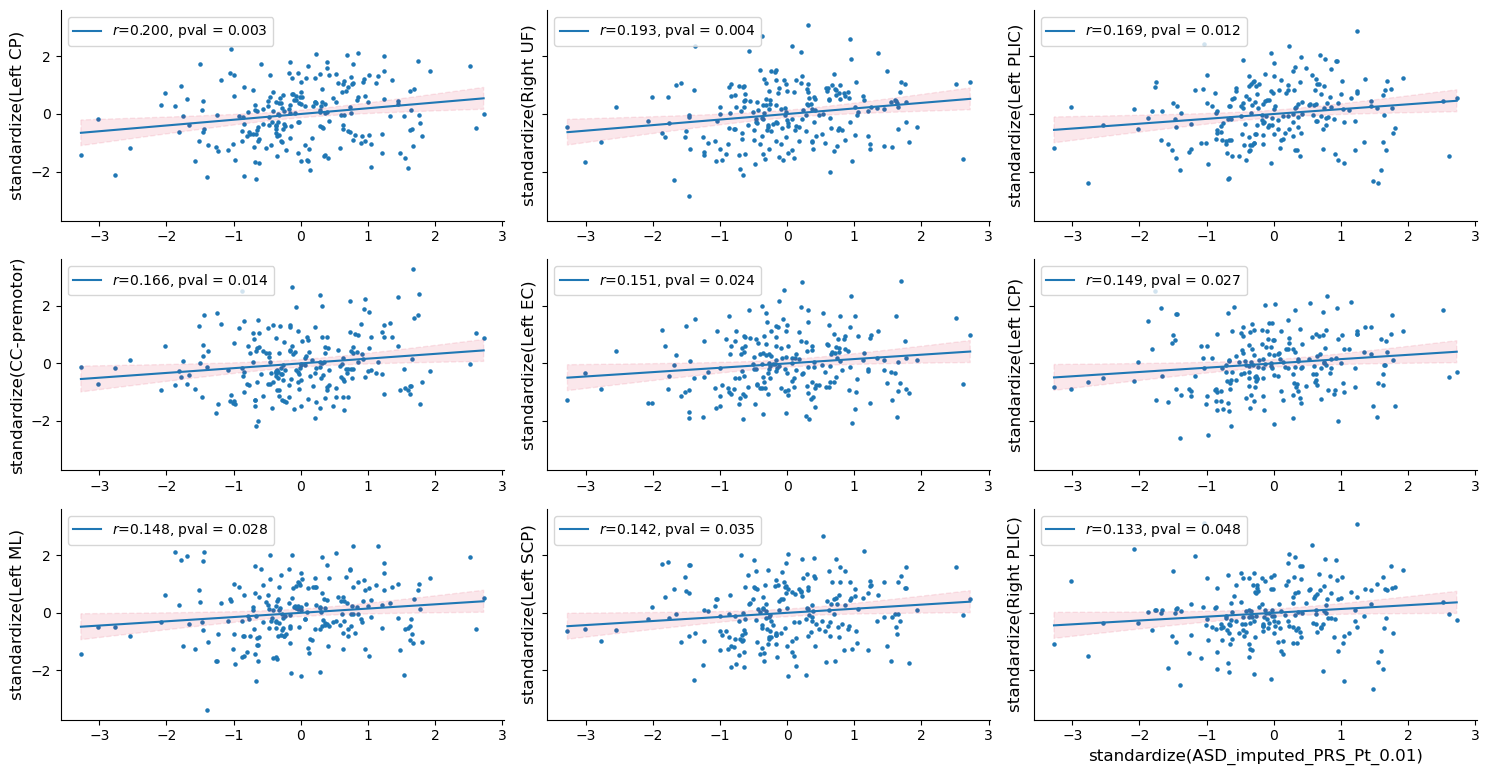

In [123]:
fig,ax = plt.subplots(3,3,figsize=(15,8),sharey=True)
visualisation.SimplePlots.Scatter(y=['wm_124_log_fc',
                                    'wm_140_log_fc',
                                    'wm_96_log_fc','wm_144_log_fc',
                                    'wm_118_log_fc','wm_136_log_fc',
                                    'wm_141_log_fc','wm_132_log_fc','wm_97_log_fc'],x=['ASD_imputed_PRS_Pt_0.01'],data=tract_volumes,
                                 adjust_covar={'y':['GA','PMA','TBV','sex'],
                                              'x':ancestry},
                                  legend_loc='upper left',
                                  scaling='both',figsize=(15,8),
                                  ax=ax,fig=fig,
                                 ylabel=['Left CP',
                                         'Right UF','Left PLIC','CC-premotor',
                                        'Left EC','Left ICP',
                                        'Left ML','Left SCP','Right PLIC'],
                                 markersize=5,fontsize=12)
sns.despine()
# ax[0].set_xlabel('standardize(ASD_imputed_PRS_Pt_0.01)',fontsize=12)
plt.tight_layout()
fig.savefig('scatter_plot.png')

In [73]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(
    tract_volumes,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['ASD_imputed_PRS_Pt_0.01','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[f'wm_{i}_log_fc' for i in range(94,148)])

In [74]:
to_plot_values = {int(k.replace('wm_','').replace('_log_fc','')):1-v for k,v in zip(mass_univariate.index.tolist(),mass_univariate["standardize(Q('ASD_imputed_PRS_Pt_0.01'))_pval"].values)}

In [86]:
test = visualisation.Brainmap.get_ROIs_coordinates('../codes/FBA/output_ASD/5TT/wm_parcellation_warped_wm_fod.nii.gz')

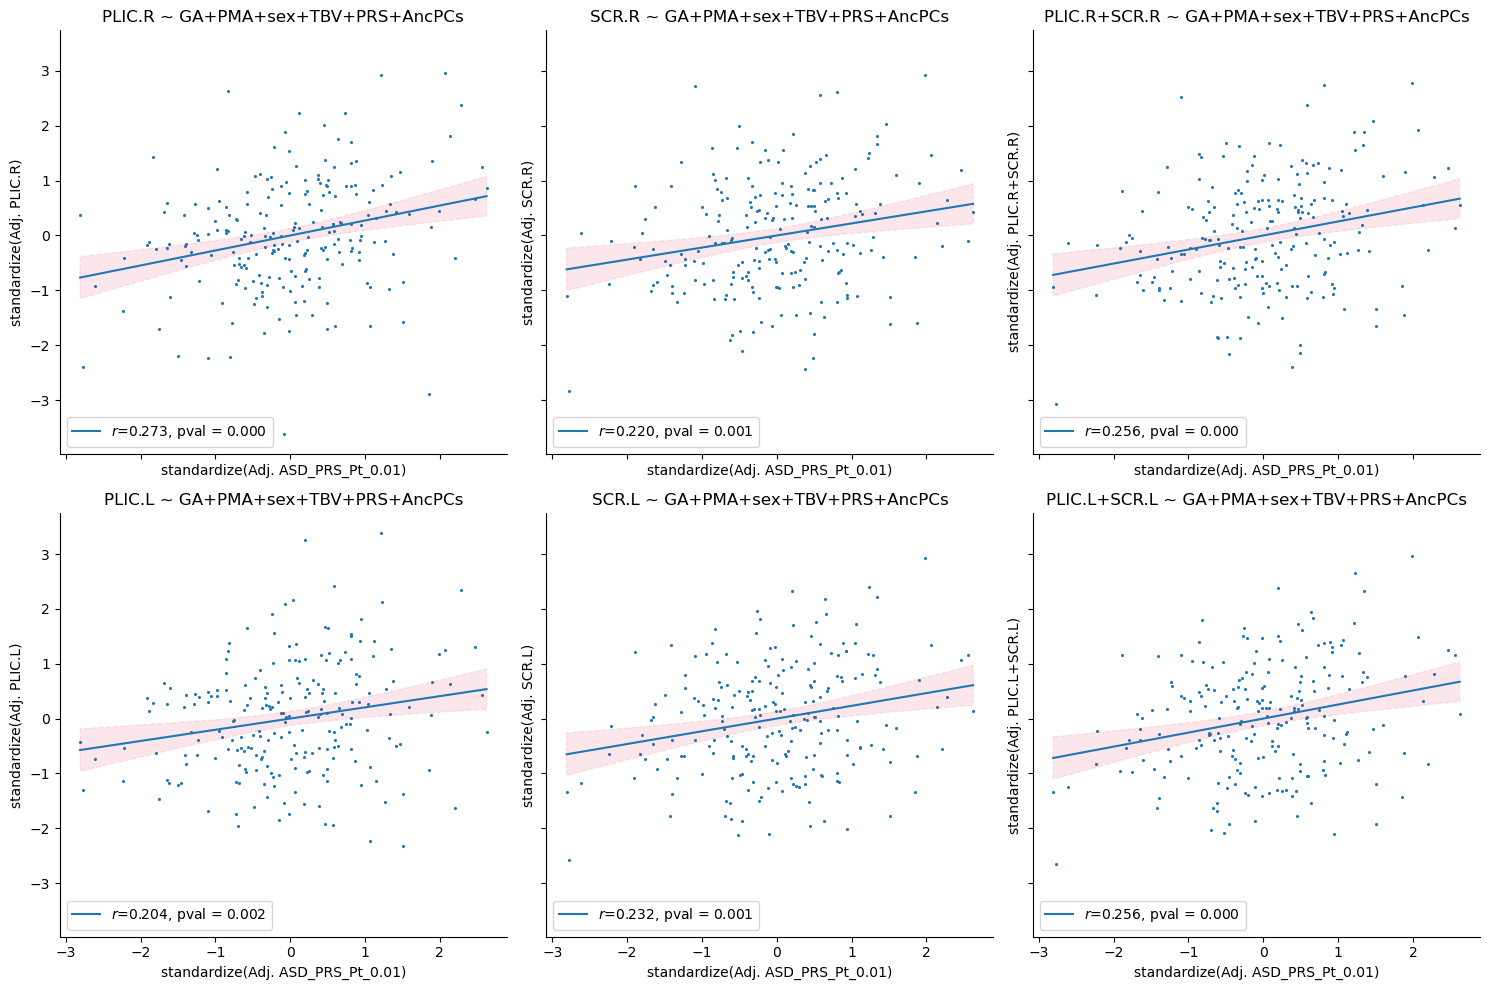

In [37]:
fig,axes=plt.subplots(2,3,sharex=True,sharey=True,figsize=(15,10))
axes=axes.flatten()
visualisation.SimplePlots.Scatter(y='wm_97',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.R ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.R',legend_loc='lower left',ax=axes[0])
visualisation.SimplePlots.Scatter(y='wm_103',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='SCR.R ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='SCR.R',legend_loc='lower left',ax=axes[1])
xxvisualisation.SimplePlots.Scatter(y='wm_97_103',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.R+SCR.R ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.R+SCR.R',legend_loc='lower left',ax=axes[2])

visualisation.SimplePlots.Scatter(y='wm_96',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.L ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.L',legend_loc='lower left',ax=axes[3])
visualisation.SimplePlots.Scatter(y='wm_102',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='SCR.L ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='SCR.L',legend_loc='lower left',ax=axes[4])
visualisation.SimplePlots.Scatter(y='wm_96_102',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.L+SCR.L ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.L+SCR.L',legend_loc='lower left',ax=axes[5])


sns.despine()
plt.tight_layout()
plt.savefig('asd/wm_volume_ASD_regression.png',dpi=300)

In [202]:
fd_mean_L = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L/mean-fd-plic_L.txt',header=None)
log_fc_mean_L = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L/mean-log_fc-plic_L.txt',header=None)
fdc_mean_L = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L/mean-fdc-plic_L.txt',header=None)

fd_mean_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_R/mean-fd-plic_R.txt',header=None)
log_fc_mean_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_R/mean-log_fc-plic_R.txt',header=None)
fdc_mean_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_R/mean-fdc-plic_R.txt',header=None)

fd_mean_L_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L_R/mean-fd-plic_L_R.txt',header=None)
log_fc_mean_L_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L_R/mean-log_fc-plic_L_R.txt',header=None)
fdc_mean_L_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L_R/mean-fdc-plic_L_R.txt',header=None)

In [59]:
mean_fixel = pd.concat([fd_mean_L,log_fc_mean_L,fdc_mean_L,
                        fd_mean_R,log_fc_mean_R,fdc_mean_R,
                        fd_mean_L_R,log_fc_mean_L_R,fdc_mean_L_R],axis=1)
mean_fixel.columns = ['FD_mean_L','log_FC_mean_L','FDC_mean_L',
                     'FD_mean_R','log_FC_mean_R','FDC_mean_R',
                     'FD_mean_L_R','log_FC_mean_L_R','FDC_mean_L_R']
tract_volumes = pd.concat([tract_volumes,mean_fixel],axis=1)

In [ ]:
fig,ax = plt.subplots(1,1)
visualisation.SimplePlots.Bar(x='threshold',
                              y='PRS_pval',
                              hue='Connection',
                              order={'x':[i for i in df.columns if 'ASD_PRS' in i]},
                              yscalelog=True,
                              hline=0.05,
                              hline_label='p<0.05',
                              rotation_x=90,
                              data=to_bar_plot,ax=ax)
ax.hlines(0.05/17/6,xmin=0.5,xmax=10.5,label='p<0.00049')
ax.legend(['p<0.05','p<0.00049','PLIC.L','SCR.L','SCR.L+PLIC.L'],loc='upper center',frameon=False,bbox_to_anchor=[1.2,0.7])
sns.despine()
ax.set_title('WM vol ~ ASD PRS')
plt.tight_layout()
plt.savefig('wm_vol_regression_ASD_bar_2.png',dpi=300)

In [60]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    tract_volumes,
    thresholds=[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['ASD_CS'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in tract_volumes.columns if '_mean' in i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.51it/s]


In [61]:
to_plot = test[['Connection','PRS_pval','threshold']].copy()

In [62]:
to_plot['type'] = to_plot['Connection'].apply(lambda x: x.split('_mean')[0])

In [63]:
to_plot['Tract'] = to_plot['Connection'].apply(lambda x: '+'.join(x.split('_mean')[1].split('_')[1:]))

In [18]:
# visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Connection',data=to_plot[to_plot['type']=='log_FC'],
#                               order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]},
#                               yscalelog=True,hline=0.05,rotation_x=90)

In [7]:
# visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Tract',data=to_plot,
#                               separateby='type',
#                              order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['ASD_CS'],
#                                    'hue':['L','R','L+R']},yscalelog=True,
#                              ylabel='$log_{10}(PRS_{p-value})$',rotation_x=90,hline=[0.05,0.01],hline_label=['p<0.05','p<0.01'],
#                              figsize=(15,5),barwidth=0.5,xlabel=None,ylabel_pos=(-.015,.6))
# plt.tight_layout()
# sns.despine()

In [95]:
log_fc_mean_L_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/cst_L_R/mean-log_fc-cst_L_R.txt',header=None,
                             names=['CST_mean_FC'])


In [97]:
tract_volumes = pd.concat([tract_volumes,log_fc_mean_L_R],axis=1)

In [99]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    tract_volumes,
    thresholds=[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['ASD_CS'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in tract_volumes.columns if 'CST_mean_FC' in i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.09it/s]


In [102]:
0.05/6

0.008333333333333333

In [101]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
5,CST_mean_FC,0.041986,2.117534e-18,-0.015296,0.020773,0.011543,0.003214,0.027322,3.700520e-06,0.052224,5.931498e-21,-0.000351,0.905532,-0.002052,0.485570,-0.000578,0.844206,0.009408,0.001557,ASD_PRS_Pt_0.01
10,CST_mean_FC,0.041847,4.034924e-18,-0.015019,0.024065,0.010393,0.007680,0.028532,1.436331e-06,0.051306,2.537298e-20,-0.000337,0.909858,-0.002548,0.392330,-0.000394,0.894077,0.007941,0.007505,ASD_PRS_PC1
11,CST_mean_FC,0.041608,6.034492e-18,-0.014544,0.028848,0.010736,0.006172,0.028673,1.310178e-06,0.051109,3.485567e-20,-0.000417,0.888875,-0.002462,0.408787,-0.000608,0.838068,0.007630,0.010442,ASD_CS
9,CST_mean_FC,0.041279,9.994179e-18,-0.013887,0.036724,0.010102,0.009556,0.028479,1.606664e-06,0.050934,4.434191e-20,-0.000546,0.854597,-0.002669,0.372681,-0.000774,0.795295,0.007499,0.012039,ASD_PRS_Pt_1
6,CST_mean_FC,0.041845,4.695079e-18,-0.015016,0.024444,0.009952,0.010616,0.029228,7.965337e-07,0.051139,3.577409e-20,-0.000374,0.900255,-0.002229,0.453753,0.000065,0.982530,0.007382,0.012446,ASD_PRS_Pt_0.05
8,CST_mean_FC,0.041230,1.188112e-17,-0.013790,0.038343,0.009974,0.010575,0.028736,1.317430e-06,0.050817,5.703297e-20,-0.000705,0.813042,-0.002661,0.375184,-0.000696,0.815677,0.007077,0.017618,ASD_PRS_Pt_0.5
7,CST_mean_FC,0.041249,1.352895e-17,-0.013829,0.038291,0.010023,0.010437,0.029264,8.598874e-07,0.050868,6.508938e-20,-0.000568,0.849677,-0.002403,0.422913,-0.000490,0.869679,0.006346,0.032780,ASD_PRS_Pt_0.1
4,CST_mean_FC,0.041852,9.423912e-18,-0.015030,0.026179,0.009931,0.011551,0.029659,6.801110e-07,0.051102,8.025388e-20,-0.001058,0.723865,-0.001848,0.537128,0.000326,0.913245,0.004732,0.110794,ASD_PRS_Pt_0.001
2,CST_mean_FC,0.040915,6.884473e-17,-0.013163,0.054164,0.009496,0.016097,0.030213,4.937421e-07,0.050243,3.209519e-19,-0.001396,0.644703,-0.001762,0.558917,0.000089,0.976299,-0.001570,0.601315,ASD_PRS_Pt_1e-05
1,CST_mean_FC,0.041102,3.429532e-17,-0.013537,0.045128,0.009441,0.016875,0.030112,5.242345e-07,0.050331,2.608486e-19,-0.001284,0.670039,-0.001678,0.576934,0.000013,0.996561,-0.001483,0.616776,ASD_PRS_Pt_1e-06


<AxesSubplot:xlabel='standardize(Adj. ASD_CS)', ylabel='standardize(Adj. CST_mean_FC)'>

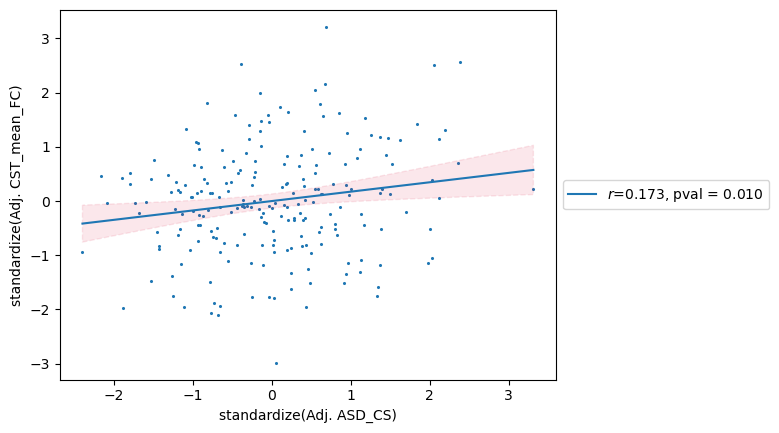

In [105]:
visualisation.SimplePlots.Scatter(x='ASD_CS',y='CST_mean_FC',data=tract_volumes,adjust_covar={'x':ancestry,
                                                                                                      'y':['sex','GA','PMA','TBV']})

In [22]:
[i for i in tract_volumes.columns if '_mean' in i]

[]

In [17]:
mass_univariate

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('ASD_PRS_Pt_0.01'))_coef,standardize(Q('ASD_PRS_Pt_0.01'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
FD_mean_L,0.521520,4.661015e-226,-0.008795,0.065095,0.002680,0.207551,0.008322,0.003274,0.009804,1.914603e-02,0.003238,3.696747e-01,0.001608,0.451374,6.533820e-08,0.999975,-0.000890,0.675608
log_FC_mean_L,0.051102,1.035423e-17,-0.019766,0.016684,0.010237,0.005657,0.010634,0.028841,0.033709,4.685450e-06,0.052367,5.771716e-15,0.000740,0.840955,-2.215420e-03,0.546155,0.000411,0.910880
FDC_mean_L,0.552939,9.811313e-190,-0.019372,0.010430,0.007898,0.019336,0.012735,0.004380,0.031009,4.192495e-06,0.028838,8.844417e-07,0.002276,0.499944,-2.082747e-03,0.535214,-0.001351,0.687693
FD_mean_R,0.528164,1.060286e-231,-0.012538,0.005990,0.002258,0.264531,0.008872,0.001022,0.009763,1.433691e-02,0.002092,5.426164e-01,0.001488,0.464382,-4.300556e-04,0.831633,0.000206,0.918863
log_FC_mean_R,0.050477,1.238076e-18,-0.012634,0.108106,0.010802,0.002296,0.008877,0.055903,0.038901,4.521876e-08,0.051919,7.578678e-16,0.001250,0.722664,-2.174437e-03,0.535383,0.000423,0.904054
FDC_mean_R,0.560174,4.528130e-196,-0.019360,0.006788,0.007698,0.015854,0.012323,0.003531,0.033541,1.696426e-07,0.028012,4.495075e-07,0.002754,0.387728,-2.155217e-03,0.497038,0.000081,0.979681
FD_mean_L_R,0.484258,3.118466e-234,-0.009513,0.019085,0.002259,0.211038,0.007486,0.001861,0.009172,9.948106e-03,0.002796,3.617327e-01,0.001506,0.406408,-2.946013e-04,0.870275,-0.000317,0.860728
log_FC_mean_L_R,0.051139,1.051791e-20,-0.015645,0.035719,0.010406,0.001901,0.009603,0.028919,0.034196,3.245736e-07,0.053207,5.920683e-18,0.000884,0.790722,-2.221656e-03,0.503006,0.000223,0.946478
FDC_mean_L_R,0.513398,4.432352e-198,-0.017446,0.006507,0.007141,0.012586,0.011077,0.003443,0.028972,4.406072e-07,0.027109,5.878052e-08,0.002284,0.424248,-2.085883e-03,0.463443,-0.000670,0.813926


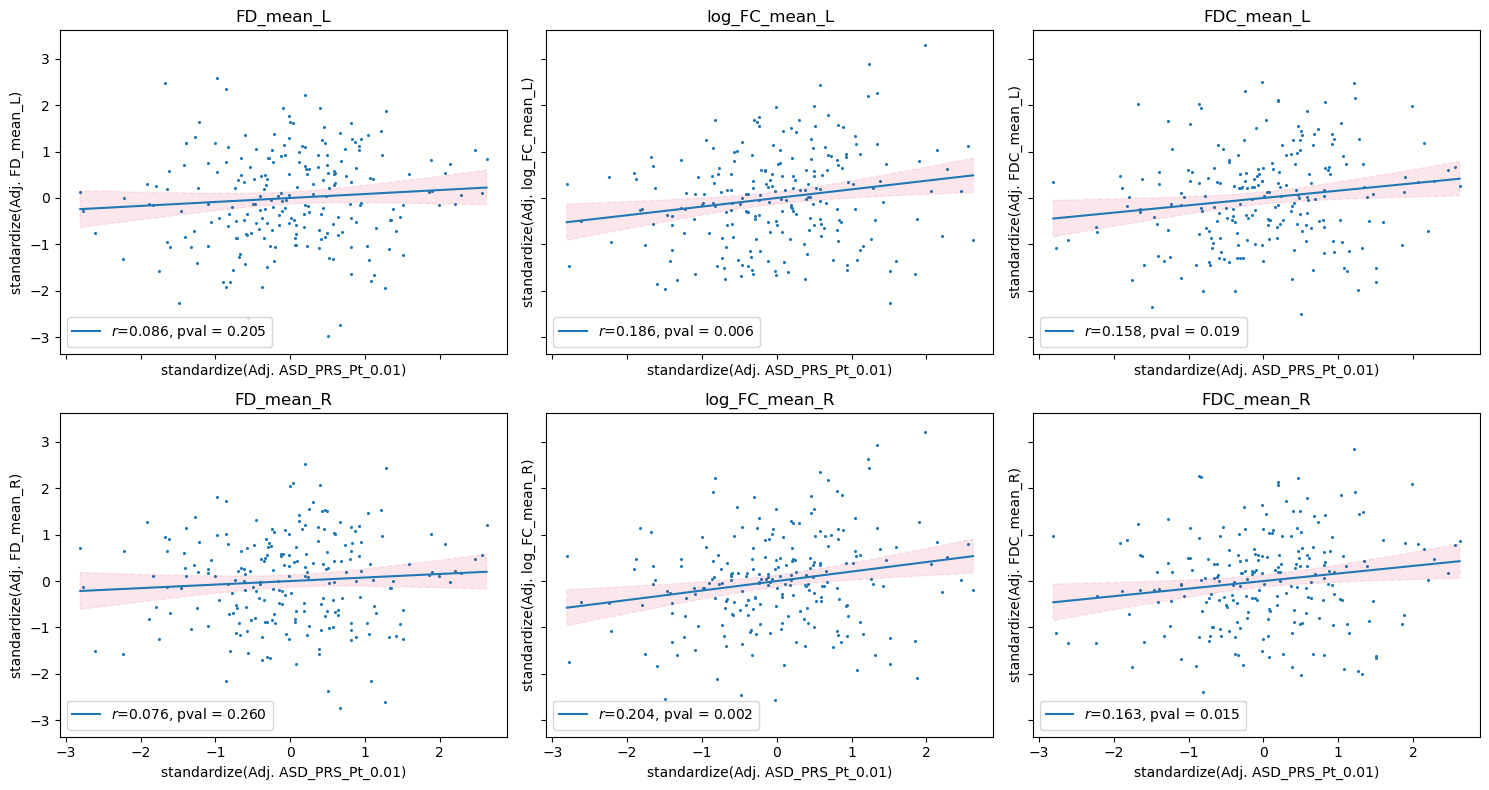

In [122]:
fig,axes=plt.subplots(2,3,sharey=True,sharex=True,figsize=(15,8))
axes = axes.flatten()
for ax,val in zip(axes,['FD_mean_L','log_FC_mean_L','FDC_mean_L',
                       'FD_mean_R','log_FC_mean_R','FDC_mean_R']):
    visualisation.SimplePlots.Scatter(x='ASD_PRS_Pt_0.01',
                                      y=val,
                                      adjust_covar={'x':ancestry,'y':['GA','PMA','TBV','sex']},
                                     data=tract_volumes,ax=ax,legend_loc='lower left',title=f'{val}')
plt.tight_layout()
plt.savefig('asd/mean_fba_together.png',dpi=300)

In [73]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
16,log_FC_mean,0.050477,1.238076e-18,-0.012634,0.108106,0.008877,0.055903,0.038901,4.521876e-08,0.051919,7.578678e-16,0.001250,0.722664,-0.002174,0.535383,0.000423,0.904054,0.010802,0.002296,ASD_PRS_Pt_0.01
17,FDC_mean,0.560174,4.528130e-196,-0.019360,0.006788,0.012323,0.003531,0.033541,1.696426e-07,0.028012,4.495075e-07,0.002754,0.387728,-0.002155,0.497038,0.000081,0.979681,0.007698,0.015854,ASD_PRS_Pt_0.01
23,FDC_mean,0.559584,4.634317e-196,-0.018184,0.010758,0.011246,0.007036,0.034837,4.701856e-08,0.027073,9.097050e-07,0.002816,0.377897,-0.002713,0.395790,-0.000080,0.979845,0.007489,0.018167,ASD_PRS_Pt_0.1
26,FDC_mean,0.559558,7.694659e-196,-0.018132,0.011170,0.011099,0.007915,0.034504,7.103731e-08,0.026923,1.088367e-06,0.002540,0.426186,-0.002800,0.383563,-0.000139,0.965391,0.006815,0.032525,ASD_PRS_Pt_0.5
22,log_FC_mean,0.049632,7.036007e-18,-0.010952,0.167083,0.007143,0.123450,0.041111,9.216355e-09,0.050373,5.589935e-15,0.001017,0.775521,-0.002596,0.467183,0.000509,0.886329,0.007442,0.035491,ASD_PRS_Pt_0.1
29,FDC_mean,0.559600,8.314434e-196,-0.018217,0.010839,0.011184,0.007511,0.034369,8.315877e-08,0.026997,1.037592e-06,0.002645,0.408221,-0.002735,0.394292,-0.000148,0.963002,0.006695,0.036196,ASD_PRS_Pt_1
28,log_FC_mean,0.049655,6.883571e-18,-0.010997,0.165375,0.007140,0.123663,0.040475,1.686701e-08,0.050355,5.718778e-15,0.000920,0.796169,-0.002726,0.446212,0.000342,0.923648,0.007453,0.036461,ASD_PRS_Pt_1
20,FDC_mean,0.560107,9.717038e-196,-0.019227,0.007380,0.011051,0.008201,0.035036,4.278905e-08,0.027181,9.026511e-07,0.002800,0.382583,-0.002344,0.462700,0.000600,0.850077,0.006603,0.036735,ASD_PRS_Pt_0.05
19,log_FC_mean,0.050219,3.732437e-18,-0.012119,0.127626,0.006991,0.131420,0.041220,8.414128e-09,0.050558,4.837234e-15,0.001091,0.760105,-0.002289,0.519895,0.001176,0.739902,0.007335,0.037399,ASD_PRS_Pt_0.05
25,log_FC_mean,0.049607,7.680881e-18,-0.010901,0.169397,0.007019,0.130187,0.040708,1.393659e-08,0.050246,6.592102e-15,0.000772,0.828462,-0.002736,0.445331,0.000405,0.909713,0.007155,0.044212,ASD_PRS_Pt_0.5


### Mediation analysis

In [14]:
log_fc_mean_L_R = pd.read_csv('../../codes/FBA/output_ASD/tractography/individual_tracts/cst_L_R/mean-log_fc-cst_L_R.txt',header=None)
log_fc_mean_L_R['ID/Ses'] = tract_metrics['ID/Ses']
log_fc_mean_L_R['ID'] = log_fc_mean_L_R['ID/Ses'].apply(lambda x: x.split('/')[0].replace('sub-',''))
log_fc_mean_L_R = log_fc_mean_L_R.rename(columns={0:'cst_log_fc'})

In [15]:
fdc_mean_L_R = pd.read_csv('../../codes/FBA/output_ASD/tractography/individual_tracts/cst_L_R/mean-fdc-cst_L_R.txt',header=None)
fdc_mean_L_R['ID/Ses'] = tract_metrics['ID/Ses']
fdc_mean_L_R['ID'] = fdc_mean_L_R['ID/Ses'].apply(lambda x: x.split('/')[0].replace('sub-',''))
fdc_mean_L_R = fdc_mean_L_R.rename(columns={0:'cst_fdc'})

In [16]:
df = df.merge(log_fc_mean_L_R[['ID','cst_log_fc']],on='ID')
df = df.merge(fdc_mean_L_R[['ID','cst_fdc']],on='ID')

In [76]:
from statsmodels.stats.mediation import Mediation,MediationResults
#https://github.com/kshedden/mediation_workshop
#https://davidakenny.net/cm/mediate.htm

In [109]:
dHCP_outcomes = pd.read_csv(f'../../dataset/participant_outcome/DHCPNDH1-LeHaiOutcome_DATA_LABELS_2022-06-09_0947.csv')
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,6,11:13,13,16:19,21:24,34,56,77:92]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,13,18,23,83:90]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,83:90]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,21, 22, 23, 24, 25, 29, 30]].copy()
dHCP_outcomes_CBCL_Bayley['Assessment Age'] = dHCP_outcomes_CBCL_Bayley['Corrected Age - Months'] + dHCP_outcomes_CBCL_Bayley['Corrected Age - Days']/30
dHCP_outcomes_CBCL_Bayley.rename(columns={'IMD Score':'IMD'},inplace=True)
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes_CBCL_Bayley.dropna()
dHCP_total_QCHAT_SCORE = dHCP_outcomes.iloc[:,np.r_[0,72]]

In [110]:
GA = pd.read_table('../../dataset/participant_info/dHCP_release3_metadata.tsv').drop_duplicates(subset=['participant_id'])

In [111]:
euro_ancestry = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/ancestry_PCs/euro_batch2_genotyped_PCA_result.eigenvec',
                                                                              column_prefix='euro_Anc_')

In [112]:
df = dHCP_outcomes_CBCL_Bayley.merge(PRS_imputed_Grove,left_on='Participant ID',right_on='ID')
# df = df.merge(PRS_imputed_Grove,left_on='participant_id',right_on='ID').merge(dHCP_outcomes_CBCL_Bayley,left_on='ID',right_on='Participant ID')
df = df.merge(euro_ancestry,on='ID')
df = df.merge(GA, left_on = 'ID', right_on = 'participant_id')
Bayleys_metrics = [i for i in df.columns for n in ['Communication','Cognitive','Motor'] if n in i]

In [113]:
df = df[df['birth_age']>=37]

In [114]:
# df = stats.MassUnivariate.remove_outliers(
#     df,
#     col=[i for i in df.columns if 'Motor' in i],
#     threshold=3.5,
#     remove_schemes='any',
#     percentage_of_outlier=0.1)

# print(df.shape)

In [115]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(df[Bayleys_metrics],rowvar=False))

Effective Number of Independent Variables [Veff] is 5.475114784536939
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 5.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.010000000000000004


4.999999999999998

In [116]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df=df,
                                                                          thresholds=[i for i in df.columns if 'ASD_imputed' in i],
                                                                                 cat_independentVar_cols=["sex"],
                                    cont_independentVar_cols=['Assessment Age','IMD']+[f'euro_Anc_PC{i}' for i in range(1,4)],
                                                                         dependentVar_cols=Bayleys_metrics)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.97it/s]


In [123]:
test[test['PRS_pval']<0.05].sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('Assessment Age'))_coef,standardize(Q('Assessment Age'))_pval,standardize(IMD)_coef,standardize(IMD)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
26,Gross Motor Scaled Score,8.848366,5.563992e-128,0.718055,0.005806,0.016249,0.896184,-0.023363,0.851726,-0.163524,0.190701,0.064917,0.609884,-0.126000,0.319795,-0.448921,0.000568,ASD_imputed_PRS_Pt_0.0001
27,Sum Motor Scaled Scores,20.656594,6.888456e-167,0.452064,0.265387,0.038531,0.843737,-0.088133,0.653344,-0.290578,0.138721,-0.111402,0.576984,-0.151225,0.446646,-0.703853,0.000576,ASD_imputed_PRS_Pt_0.0001
21,Cognitive Scaled Score,10.848254,1.689508e-150,-0.497722,0.048314,-0.249801,0.039922,-0.072932,0.548479,0.074056,0.541559,-0.279137,0.024719,0.055279,0.653165,-0.327139,0.009393,ASD_imputed_PRS_Pt_0.0001
20,Sum Motor Scaled Scores,20.723415,1.334810e-166,0.318957,0.432314,0.053924,0.784996,-0.033486,0.865889,-0.295953,0.135968,-0.227365,0.259022,-0.123102,0.539472,-0.515156,0.010989,ASD_imputed_PRS_Pt_1e-05
23,Expressive Communication Scaled Score,9.859711,3.765678e-121,-0.672544,0.030479,0.177797,0.233907,-0.280469,0.061931,0.151057,0.312515,-0.162212,0.287529,0.335797,0.027465,-0.386179,0.012772,ASD_imputed_PRS_Pt_0.0001
41,Sum Motor Scaled Scores,20.783649,1.421041e-167,0.198971,0.619200,0.080378,0.685109,-0.068583,0.729626,-0.345403,0.084371,-0.132199,0.513277,-0.103380,0.606526,-0.496772,0.013900,ASD_imputed_PRS_Pt_0.01
48,Sum Motor Scaled Scores,20.780437,1.812653e-167,0.205370,0.608417,0.083275,0.674726,-0.062131,0.754248,-0.363399,0.071147,-0.115440,0.570149,-0.154493,0.443750,-0.491433,0.016219,ASD_imputed_PRS_Pt_0.05
40,Gross Motor Scaled Score,8.930175,7.601748e-129,0.555091,0.030426,0.042312,0.737774,-0.010565,0.933446,-0.197311,0.121817,0.050463,0.695434,-0.095626,0.455095,-0.306525,0.017247,ASD_imputed_PRS_Pt_0.01
47,Gross Motor Scaled Score,8.928652,1.045362e-128,0.558124,0.029798,0.043724,0.729738,-0.006477,0.959195,-0.207565,0.105880,0.059963,0.643751,-0.126661,0.325110,-0.297646,0.022370,ASD_imputed_PRS_Pt_0.05
33,Gross Motor Scaled Score,8.913402,3.151379e-128,0.588502,0.022858,0.023689,0.851206,0.005857,0.963107,-0.184686,0.146496,0.048351,0.707906,-0.101214,0.429751,-0.290525,0.024403,ASD_imputed_PRS_Pt_0.001


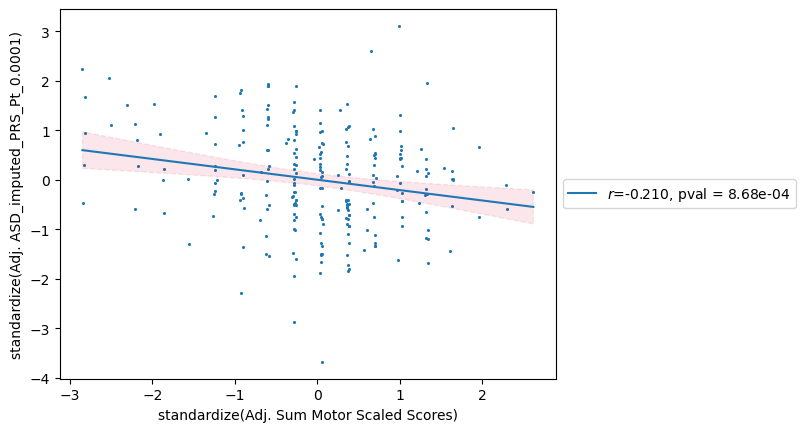

In [122]:
visualisation.SimplePlots.Scatter(
    x='Sum Motor Scaled Scores',
    y='ASD_imputed_PRS_Pt_0.0001',
    adjust_covar={'x':['IMD','Assessment Age','sex'],
                 'y':ancestry},
    data=df
    )

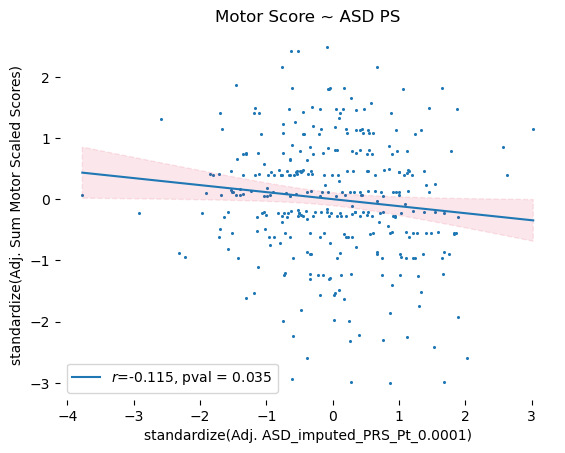

In [242]:
visualisation.SimplePlots.Scatter(
x='ASD_imputed_PRS_Pt_0.0001',y='Sum Motor Scaled Scores',data=df,
    adjust_covar={'x':ancestry,'y':['Assessment Age','IMD','sex']},
    title='Motor Score ~ ASD PS',legend_loc='lower left')
sns.despine(bottom=True,left=True)
# plt.tight_layout()
# plt.savefig('motor_score.png',dpi=300)

In [175]:
0.05/2/6

0.004166666666666667

In [345]:
# stats.MultipleCorrection.fdr(test,p_val='PRS_pval')
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.Male]_coef,C(sex)[T.Male]_pval,standardize(Q('Assessment Age'))_coef,standardize(Q('Assessment Age'))_pval,standardize(IMD)_coef,standardize(IMD)_pval,standardize(Q('euro_Anc_PC1'))_coef,...,standardize(Q('euro_Anc_PC7'))_pval,standardize(Q('euro_Anc_PC8'))_coef,standardize(Q('euro_Anc_PC8'))_pval,standardize(Q('euro_Anc_PC9'))_coef,standardize(Q('euro_Anc_PC9'))_pval,standardize(Q('euro_Anc_PC10'))_coef,standardize(Q('euro_Anc_PC10'))_pval,PRS_coef,PRS_pval,threshold
10,Gross Motor Scaled Score,8.857492,2.680026e-170,0.496182,0.019076,-0.100140,0.347666,-0.034286,0.741402,-0.017496,...,0.684645,0.087377,0.437283,0.020313,0.852210,-0.103771,0.351087,-0.307987,0.003875,ASD_imputed_PRS_Pt_0.0001
7,Gross Motor Scaled Score,8.876298,1.728701e-170,0.461496,0.028852,-0.062767,0.554304,-0.007447,0.943216,-0.034849,...,0.744932,0.091811,0.415965,0.035870,0.742860,-0.123486,0.268600,-0.262034,0.014146,ASD_imputed_PRS_Pt_1e-05
11,Sum Motor Scaled Scores,20.691398,1.134259e-218,-0.008578,0.979782,-0.134915,0.430697,-0.108003,0.517549,-0.108691,...,0.122389,0.227389,0.208475,-0.024160,0.890260,-0.209217,0.241930,-0.352153,0.039116,ASD_imputed_PRS_Pt_0.0001
19,Gross Motor Scaled Score,8.904263,5.859575e-171,0.409915,0.051109,-0.065289,0.540028,-0.033615,0.748116,-0.046579,...,0.774906,0.097115,0.391110,0.027535,0.801960,-0.109227,0.329839,-0.205268,0.053235,ASD_imputed_PRS_Pt_0.05
8,Sum Motor Scaled Scores,20.708807,4.486361e-219,-0.040689,0.903868,-0.092321,0.587042,-0.075090,0.653834,-0.130184,...,0.139432,0.231457,0.200707,-0.006186,0.971816,-0.232297,0.193930,-0.329301,0.053746,ASD_imputed_PRS_Pt_1e-05
20,Sum Motor Scaled Scores,20.741479,8.360427e-220,-0.100950,0.762762,-0.096628,0.569876,-0.109958,0.510557,-0.152901,...,0.156570,0.237049,0.190009,-0.018692,0.915042,-0.211489,0.237321,-0.320214,0.058817,ASD_imputed_PRS_Pt_0.05
17,Sum Motor Scaled Scores,20.742117,1.922512e-219,-0.102127,0.760770,-0.099889,0.558155,-0.107852,0.519772,-0.145356,...,0.128391,0.245186,0.176345,-0.021092,0.904505,-0.219852,0.220200,-0.236715,0.160917,ASD_imputed_PRS_Pt_0.01
1,Gross Motor Scaled Score,8.928262,1.180974e-170,0.365650,0.083828,-0.057026,0.593617,-0.029717,0.777026,-0.018315,...,0.590844,0.109143,0.337180,0.035265,0.748612,-0.130394,0.247020,0.148002,0.161168,ASD_imputed_PRS_Pt_1e-08
13,Gross Motor Scaled Score,8.897666,3.125531e-170,0.422082,0.046077,-0.076088,0.478604,-0.028105,0.788829,-0.028249,...,0.673667,0.103800,0.360826,0.036352,0.741196,-0.109109,0.332274,-0.144356,0.172317,ASD_imputed_PRS_Pt_0.001
16,Gross Motor Scaled Score,8.905178,1.481255e-170,0.408227,0.052888,-0.066998,0.530970,-0.031927,0.761095,-0.040342,...,0.692625,0.102222,0.368141,0.026533,0.809753,-0.114859,0.306725,-0.141836,0.180164,ASD_imputed_PRS_Pt_0.01


In [23]:
df = df.merge(dHCP_outcomes_CBCL_Bayley,left_on='ID',right_on='Participant ID')

In [263]:
outcome_exog = df[['sex','TBV','GA','PMA','Assessment Age','IMD','ASD_imputed_PRS_Pt_0.01','cst_log_fc']+ancestry].copy()
outcome_exog['sex'] = outcome_exog['sex'].apply(lambda x: 1 if x == 'female' else 0)
outcome_endog = df[['Sum Motor Scaled Scores']].copy()
outcome_exog = stats.sm.add_constant(outcome_exog)

In [264]:
outcome_model = stats.sm.OLS(outcome_endog,outcome_exog)

In [265]:
mediator_exog = df[['sex','TBV','GA','PMA','wm_102_log_fc']+ancestry].copy()
mediator_exog['sex'] = mediator_exog['sex'].apply(lambda x: 1 if x == 'female' else 0)
mediator_endog = df[['ASD_PRS_Pt_0.01']].copy()
mediator_exog = stats.sm.add_constant(mediator_exog)
mediator_model = stats.sm.OLS(mediator_endog,mediator_exog)

In [266]:
outcome_model.fit().params

const                     -5.561160e+00
sex                       -3.875817e-01
TBV                       -7.765622e-07
GA                         5.558733e-01
PMA                       -1.322458e-01
Assessment Age             1.185368e-01
IMD                       -2.050928e-04
ASD_imputed_PRS_Pt_0.01   -2.637463e+03
cst_log_fc                -1.285665e-01
euro_Anc_PC1              -1.114272e+01
euro_Anc_PC2              -8.503477e-01
euro_Anc_PC3              -6.063973e+00
dtype: float64

In [267]:
mediator_model.fit().params

const           -6.818678e-04
sex             -2.321909e-05
TBV             -3.252875e-09
GA              -1.900860e-05
PMA              1.158843e-05
wm_102_log_fc    1.746699e-03
euro_Anc_PC1    -6.342656e-04
euro_Anc_PC2     2.682066e-04
euro_Anc_PC3     3.596851e-04
dtype: float64

In [268]:
mediator = 7
exposure = (8,5)

In [269]:
test = Mediation(outcome_model=outcome_model,
         mediator_model=mediator_model,
         exposure=exposure,
         mediator=mediator).fit()

In [271]:
test.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-4.538758,-9.174129,-0.790547,0.018
ACME (treated),-4.538758,-9.174129,-0.790547,0.018
ADE (control),-0.226399,-12.604262,11.580369,0.970
ADE (treated),-0.226399,-12.604262,11.580369,0.970
Total effect,-4.765157,-16.926864,6.904351,0.432
Prop. mediated (control),0.542553,-7.062017,12.303556,0.438
Prop. mediated (treated),0.542553,-7.062017,12.303556,0.438
ACME (average),-4.538758,-9.174129,-0.790547,0.018
ADE (average),-0.226399,-12.604262,11.580369,0.970
Prop. mediated (average),0.542553,-7.062017,12.303556,0.438


In [256]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df=df,
                                                                          thresholds=[i for i in df.columns if '_log_fc' in i],
                                    cat_independentVar_cols=['sex'],
                                    cont_independentVar_cols=['TBV','GA','PMA','Assessment Age','IMD'],
                                                                         dependentVar_cols=['Sum Motor Scaled Scores'])

100%|███████████████████████████████████████| 55/55 [00:01<00:00, 44.66it/s]


In [262]:
data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()['wm_142']

{'name': 'medial lemniscus right',
 'side': 'right',
 'segment': None,
 'structure': 'medial lemniscus',
 'abbr': 'ML.right'}

In [261]:
stats.MassUnivariate.mass_univariate(
    df=df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['TBV','GA','PMA','ASD_imputed_PRS_Pt_0.05']+ancestry,
    dependentVar_cols=['wm_130_log_fc'])[1]

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(Q('ASD_imputed_PRS_Pt_0.05'))_coef,standardize(Q('ASD_imputed_PRS_Pt_0.05'))_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
wm_130_log_fc,0.035976,9.342025e-13,-0.014045,0.049311,0.068255,8.218943e-27,0.018485,0.000031,-0.01448,0.022457,0.000156,0.960373,-0.00073,0.822812,-0.000668,0.83439,0.000478,0.880671


In [ ]:
test.sort_values(by='')

In [257]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(Q('Assessment Age'))_coef,standardize(Q('Assessment Age'))_pval,standardize(IMD)_coef,standardize(IMD)_pval,PRS_coef,PRS_pval,threshold
36,Sum Motor Scaled Scores,20.830841,7.892971e-116,0.166212,0.764243,0.819248,0.151087,0.889524,0.011875,-0.358416,0.467312,0.151925,0.530894,-0.113533,0.639150,-1.037671,0.020842,wm_130_log_fc
48,Sum Motor Scaled Scores,20.843121,2.079268e-115,0.141381,0.800397,0.723251,0.205244,0.730593,0.031372,0.047364,0.924200,0.137057,0.573375,-0.090671,0.708331,-1.138981,0.037936,wm_142_log_fc
42,Sum Motor Scaled Scores,20.766743,9.935934e-116,0.295817,0.591492,0.562745,0.283589,0.763266,0.025842,0.045304,0.927571,0.115088,0.637606,-0.090438,0.709204,-1.015754,0.042639,wm_136_log_fc
47,Sum Motor Scaled Scores,20.810059,1.881194e-115,0.208232,0.708155,0.550710,0.303410,0.747707,0.028867,0.041841,0.933328,0.150214,0.537600,-0.079181,0.744270,-0.978426,0.057203,wm_141_log_fc
44,Sum Motor Scaled Scores,20.839458,5.534566e-115,0.148788,0.791714,0.505941,0.344031,0.760451,0.027375,-0.108905,0.824069,0.163366,0.503018,-0.077912,0.748536,-0.819142,0.075236,wm_138_log_fc
43,Sum Motor Scaled Scores,20.794491,2.107046e-115,0.239711,0.666160,0.575698,0.306579,0.721130,0.034380,0.030311,0.951784,0.126788,0.604444,-0.082337,0.734851,-0.963102,0.077815,wm_137_log_fc
37,Sum Motor Scaled Scores,20.831624,4.953957e-115,0.164629,0.769676,0.583609,0.305000,0.819068,0.020590,-0.276898,0.574527,0.164695,0.499702,-0.080080,0.741882,-0.790548,0.080830,wm_131_log_fc
15,Sum Motor Scaled Scores,20.755478,2.467501e-115,0.318595,0.565120,0.510917,0.376809,0.747235,0.030853,-0.191802,0.695708,0.151242,0.536406,-0.098232,0.687398,-0.738219,0.129627,wm_109_log_fc
49,Sum Motor Scaled Scores,20.777415,3.348101e-115,0.274238,0.622045,0.541924,0.374419,0.633131,0.061127,-0.577791,0.309327,0.205743,0.404038,-0.115398,0.638207,-0.565878,0.150892,wm_143_log_fc
21,Sum Motor Scaled Scores,20.715599,4.235194e-115,0.399229,0.471897,0.272918,0.576940,0.597659,0.077981,-0.275931,0.578414,0.179900,0.462817,-0.055821,0.819182,-0.467643,0.153703,wm_115_log_fc


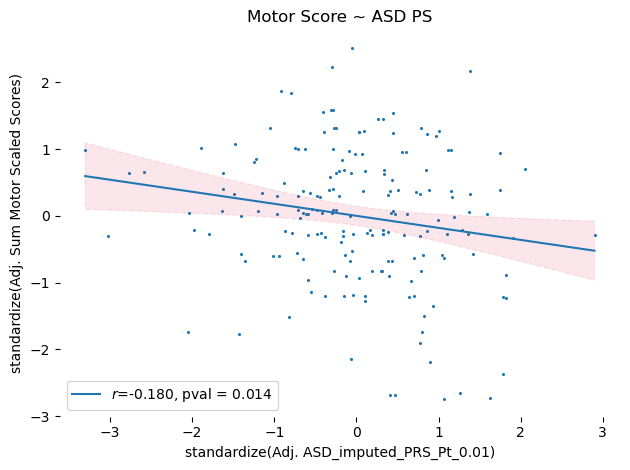

In [295]:
visualisation.SimplePlots.Scatter(
x='ASD_imputed_PRS_Pt_0.01',y='Sum Motor Scaled Scores',data=df,
    adjust_covar={'x':ancestry,'y':['Assessment Age','IMD','sex']},
    title='Motor Score ~ ASD PS',legend_loc='lower left')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('motor_score.png',dpi=300)

In [223]:
test.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),118.936852,-452.575954,790.197801,0.710
ACME (treated),118.936852,-452.575954,790.197801,0.710
ADE (control),-2743.775482,-4873.717908,-736.504730,0.008
ADE (treated),-2743.775482,-4873.717908,-736.504730,0.008
Total effect,-2624.838630,-4690.037580,-727.189036,0.010
Prop. mediated (control),-0.034351,-0.458496,0.222756,0.716
Prop. mediated (treated),-0.034351,-0.458496,0.222756,0.716
ACME (average),118.936852,-452.575954,790.197801,0.710
ADE (average),-2743.775482,-4873.717908,-736.504730,0.008
Prop. mediated (average),-0.034351,-0.458496,0.222756,0.716


In [87]:
outcome_model,_ = stats.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['TBV','GA','PMA','Assessment Age','IMD','ASD_imputed_PRS_Pt_0.01','wm_102_log_fc']+ancestry,
    dependentVar_cols=['Sum Motor Scaled Scores'])

In [144]:
outcome_model.model

In [92]:
mediator_model,_ = stats.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['TBV','GA','PMA','ASD_imputed_PRS_Pt_0.01']+ancestry,
    dependentVar_cols=['wm_102_log_fc'])

In [101]:
exposure = (7,5)
mediator = 8

In [108]:
?stats.MassUnivariate.prepare_data

In [122]:
outcome_categorical,outcome_independent,outcome_dependent = stats.MassUnivariate.prepare_data(return_type='dataframe',df=df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['TBV','GA','PMA','Assessment Age','IMD','ASD_imputed_PRS_Pt_0.01','wm_102_log_fc']+ancestry,
    dependentVar_cols=['Sum Motor Scaled Scores'],scaling=True)

In [151]:
test = Mediation(outcome_model=outcome_model.model,
         mediator_model=mediator_model.model,
         exposure=exposure,
         mediator=mediator).fit()

AttributeError: 'dict' object has no attribute 'loc'

In [149]:
test.

(7, 5)

In [60]:
fc_adjusted = stats.MassUnivariate.adjust_covariates_with_lin_reg(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['TBV','GA','PMA'],
    dependentVar_cols=[i for i in df.columns if '_log_fc' in i])

In [58]:
prs_adjusted = stats.MassUnivariate.adjust_covariates_with_lin_reg(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=[i for i in df.columns if 'ASD_imputed_PRS' in i])

In [71]:
prs_102_fc_adjusted = stats.MassUnivariate.adjust_covariates_with_lin_reg(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=ancestry+['GA','PMA','TBV','wm_102_log_fc'],
    dependentVar_cols=[i for i in df.columns if 'ASD_imputed_PRS' in i])

In [65]:
motor_adjusted = stats.MassUnivariate.adjust_covariates_with_lin_reg(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['Assessment Age','IMD'],
    dependentVar_cols=[i for i in df.columns if 'Motor' in i])

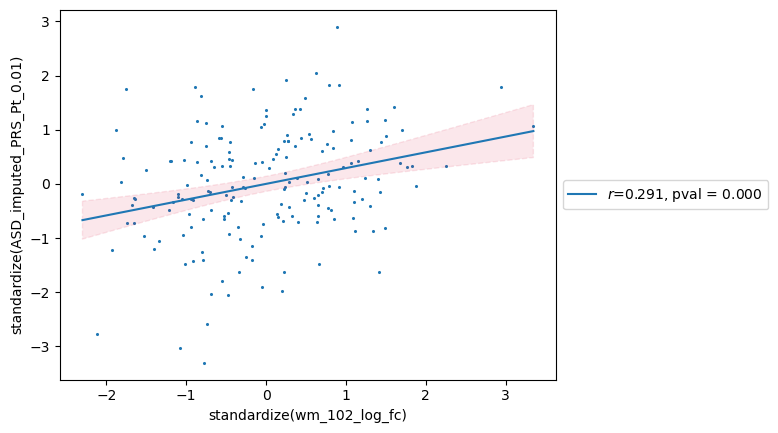

In [67]:
visualisation.SimplePlots.Scatter(
    x=fc_adjusted['wm_102_log_fc'],
    y=prs_adjusted['ASD_imputed_PRS_Pt_0.01'])

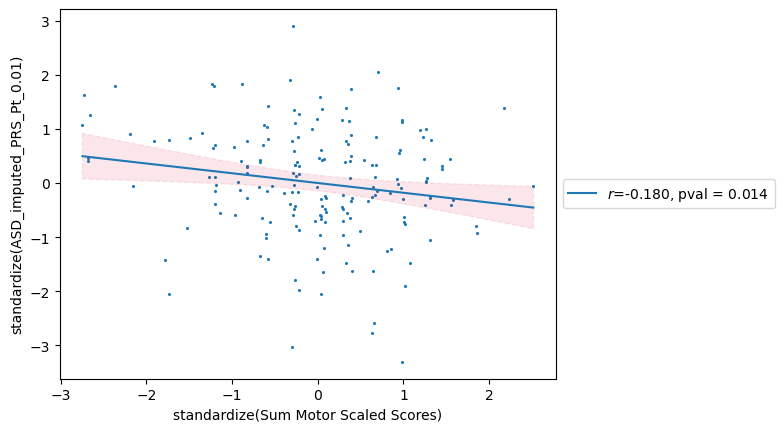

In [68]:
visualisation.SimplePlots.Scatter(
    x=motor_adjusted['Sum Motor Scaled Scores'],
    y=prs_adjusted['ASD_imputed_PRS_Pt_0.01'])

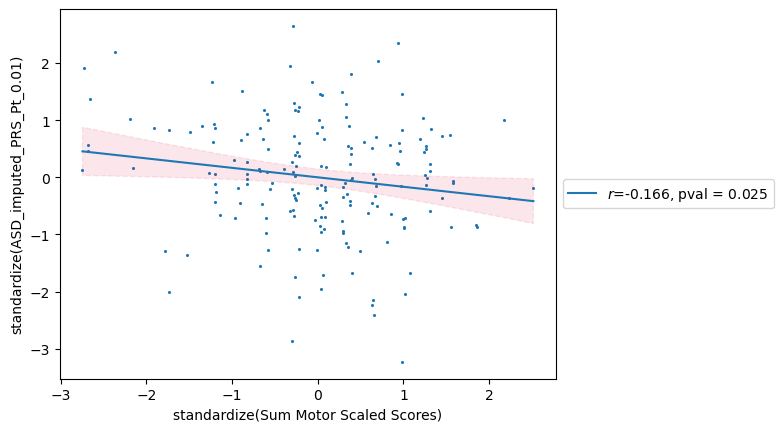

In [72]:
visualisation.SimplePlots.Scatter(
    x=motor_adjusted['Sum Motor Scaled Scores'],
    y=prs_102_fc_adjusted['ASD_imputed_PRS_Pt_0.01'])

In [ ]:
stats.MassUnivariate.mass_univariate(
    df=None,
    cont_independentVar_cols=fc_adjusted[''])

In [52]:
test[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Q('Sum Motor Scaled Scores')   R-squared:                       0.082
Model:                                      OLS   Adj. R-squared:                  0.024
Method:                           Least Squares   F-statistic:                     1.403
Date:                          Thu, 14 Sep 2023   Prob (F-statistic):              0.175
Time:                                  15:33:40   Log-Likelihood:                -470.95
No. Observations:                           184   AIC:                             965.9
Df Residuals:                               172   BIC:                             1004.
Df Model:                                    11                                         
Covariance Type:                      nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    20.7247      0.363     57.122      0.000      20.009      21.441
C(sex)[T.male]                                0.3809      0.553      0.689      0.492      -0.710       1.472
standardize(Q('ASD_imputed_PRS_Pt_0.01'))    -0.5802      0.256     -2.270      0.024      -1.085      -0.076
standardize(Q('Assessment Age'))              0.2104      0.245      0.860      0.391      -0.273       0.693
standardize(IMD)                             -0.0540      0.244     -0.221      0.825      -0.536       0.428
standardize(PMA)                             -0.2243      0.490     -0.458      0.647      -1.191       0.742
standardize(Q('wm_102_log_fc'))              -0.1442      0.584     -0.247      0.805      -1.298       1.009
standardize(TBV)                              0.0799      0.650      0.123      0.902      -1.203       1.363
standardize(GA)                               0.6722      0.337      1.997      0.047       0.008       1.337
standardize(Q('euro_Anc_PC1'))               -0.5276      0.252     -2.091      0.038      -1.026      -0.029
standardize(Q('euro_Anc_PC2'))               -0.0394      0.248     -0.159      0.874      -0.529       0.450
standardize(Q('euro_Anc_PC3'))               -0.1971      0.248     -0.794      0.428      -0.687       0.293
==============================================================================
Omnibus:                        2.626   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                2.212
Skew:                          -0.243   Prob(JB):                        0.331
Kurtosis:                       3.228   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    test,
    threshold_prefix='FBA',
    thresholds=[i for i in test.columns if 'mean' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['Assessment Age','IMD','PMA'],
    dependentVar_cols=[i for i in test.columns if 'Scaled' in i])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.31it/s]


In [27]:
[i for i in test.columns if 'Motor Scaled' in i]

['Fine Motor Scaled Score',
 'Gross Motor Scaled Score',
 'Sum Motor Scaled Scores']

In [ ]:
test['']

In [48]:
mass_univariate.sort_values(by='FBA_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('Assessment Age'))_coef,standardize(Q('Assessment Age'))_pval,standardize(IMD)_coef,standardize(IMD)_pval,standardize(PMA)_coef,standardize(PMA)_pval,FBA_coef,FBA_pval,threshold
42,Cognitive Scaled Score,10.685531,3.467423e-115,-0.375139,0.170569,-0.400859,0.003602,-0.076360,0.571923,0.214763,0.179392,0.385196,0.016690,FD_mean_L_R
0,Cognitive Scaled Score,10.696106,2.323411e-115,-0.396522,0.146383,-0.409759,0.002960,-0.078203,0.562745,0.236599,0.129140,0.370876,0.017661,FD_mean_L
21,Cognitive Scaled Score,10.674418,1.075762e-114,-0.352670,0.201515,-0.391813,0.004518,-0.084204,0.533935,0.233532,0.143127,0.355831,0.026886,FD_mean_R
35,Cognitive Scaled Score,10.732151,2.250999e-115,-0.469404,0.086348,-0.372296,0.007338,-0.065170,0.632118,0.046462,0.840621,0.453514,0.049211,FDC_mean_R
56,Cognitive Scaled Score,10.736775,2.570016e-115,-0.478753,0.080790,-0.383918,0.005616,-0.063277,0.642604,0.070349,0.756979,0.428746,0.059049,FDC_mean_L_R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,Expressive Communication Scaled Score,9.873272,5.549677e-89,-0.589912,0.107849,0.030101,0.868107,-0.179925,0.318400,0.422737,0.164659,-0.026385,0.930248,log_FC_mean_L
53,Fine Motor Scaled Score,11.859814,4.561526e-111,-0.364898,0.260112,0.200527,0.208501,-0.013567,0.931644,0.026346,0.925657,-0.013946,0.960430,log_FC_mean_L_R
11,Fine Motor Scaled Score,11.860600,1.951220e-111,-0.366487,0.253392,0.200857,0.206987,-0.013175,0.933455,0.022295,0.933163,-0.009329,0.971823,log_FC_mean_L
50,Receptive Communication Scaled Score,11.551982,3.412989e-90,-1.050161,0.013687,-0.076674,0.712080,-0.116685,0.572234,0.326338,0.376565,0.006687,0.985463,log_FC_mean_L_R


# Batch 2 genetics by Hai

In [44]:
cohort_output = 'EUR_SAS'
root='batch2_%s_genotyped.50'%cohort_output

In [45]:
full_dataset = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/combined_imaging_full_dataset_release3.csv')
full_dataset = full_dataset[(full_dataset['radiology_score']<5)&(full_dataset['radiology_low_image_quality']==False)]
full_dataset = full_dataset[(full_dataset['GA']>=37) & (full_dataset['PMA']>=37) & (~full_dataset['Imperial 1'].isna())]

In [46]:
Anc_PCs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/preprocessed_dataset/batch2_HAI/%s/%s.pca.eigenvec'%(cohort_output,root),
                                                                        column_prefix='euro_Anc_')
cohort='european'
europeans = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/preprocessed_dataset/batch2_HAI/%s/%s.pca.eigenvec'%(cohort,f'batch2_{cohort}_genotyped.50'),
                                                                        column_prefix='euro_Anc_')

In [47]:
SCZ_prs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/preprocessed_dataset/batch2_HAI/%s/PRS/PRSice/%s.SCZ.all_score'%(cohort_output,root),
                                                              column_prefix='SCZ_PRS_')
SCZ_prs_cs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/preprocessed_dataset/batch2_HAI/%s/PRS/PScs/%s.SCZ.PRScs.profile'%(cohort_output,root),
                                                                           column_prefix='SCZ_PRS_',column_suffix='_CS')[['ID','SCZ_PRS_SCORESUM_CS']]


In [48]:
european_volumetric_term = pd.merge(SCZ_prs,Anc_PCs,on='ID').merge(full_dataset,on='ID').merge(SCZ_prs_cs,on='ID')

In [49]:
ASD_prs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/preprocessed_dataset/batch2_HAI/%s/PRS/PRSice/%s.ASD.all_score'%(cohort_output,root),
                                                              column_prefix='ASD_PRS_')
# ASD_prs_cs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/preprocessed_dataset/batch2_HAI/%s/PRS/PScs/%s.ASD.PRScs.profile'%(cohort_output,root),
#                                                                            column_prefix='ASD_PRS_',column_suffix='_CS')[['ID','ASD_PRS_SCORESUM_CS']]
european_volumetric_term = pd.merge(european_volumetric_term,ASD_prs,on='ID')

In [50]:
df = european_volumetric_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)
# df = df.drop(columns='ASD_Spark_imputed_PRS_Pt_1e-07')

# pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
#     df,
#     dependentVar_cols=[i for i in df.columns if 'ASD_Spark_imputed_' in i],
#     scaling=True,
#     n_components=1
# )

# df['ASD_PRS_PC1'] = prs_pca

In [51]:
available_dwi = pd.read_csv('../../codes/FBA/subject_lists/available_dwi.txt',header=None,names=['ID','Session'])
available_dwi['ID/Ses'] = available_dwi['ID']+'/'+available_dwi['Session'].astype('str')

In [52]:
df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

In [53]:
df = pd.merge(available_dwi[['ID/Ses']],df,on=['ID/Ses'],how='inner')

In [54]:
df = stats.MassUnivariate.remove_outliers(
    df,
    col=['ICV','TBV','WM','GM'],
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

In [55]:
[i for i in df.columns if 'ASD_PRS' in i]

['ASD_PRS_Pt_1e-08',
 'ASD_PRS_Pt_1e-06',
 'ASD_PRS_Pt_1e-05',
 'ASD_PRS_Pt_0.0001',
 'ASD_PRS_Pt_0.001',
 'ASD_PRS_Pt_0.01',
 'ASD_PRS_Pt_0.05',
 'ASD_PRS_Pt_0.1',
 'ASD_PRS_Pt_0.5',
 'ASD_PRS_Pt_1']

In [60]:
ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 11)]  # remove any ancestry outliers
PRS_thresholds = [i for i in df.columns if '_PRS' in i]
to_copy = df[['ID/Ses','sex','GA','PMA','TBV']+ancestry + PRS_thresholds]

In [61]:
with open('../../codes/FBA/subject_lists/batch2_HAI_EUR_SAS_available_dwi_with_PRS_after_ancestry_outliers.txt','w') as file:
    file.write(' '.join(["#"] + to_copy.columns.tolist()) + '\n')
    to_copy.to_csv(file,header=None,index=None)

In [63]:
def concat_files(files):
    to_return = pd.DataFrame()
    for variable,file in files.items():
        temp = pd.read_csv(file,delim_whitespace=True,header=None)
        temp.columns = ['ID/Ses']+[f'wm_{i}_{variable}' for i in range(94,148)]
        temp = temp.drop_duplicates('ID/Ses')
        temp['ID/Ses'] = temp['ID/Ses'].apply(lambda x: x.replace('_','/'))
        temp = temp.set_index('ID/Ses')
        to_return = pd.concat([to_return,temp],axis=1)
    return to_return.reset_index()

In [64]:
tract_metrics = concat_files({'fd':'../../codes/FBA/output_batch2_EUR_SAS_HAI/aba/mean_fd_not_smoothed_linear.txt',
                     'log_fc':'../../codes/FBA/output_batch2_EUR_SAS_HAI/aba/mean_log_fc_not_smoothed_linear.txt',
                     'fdc':'../../codes/FBA/output_batch2_EUR_SAS_HAI/aba/mean_fdc_not_smoothed_linear.txt'})

In [65]:
df = pd.merge(tract_metrics,df,on='ID/Ses')

In [84]:
ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 11)]  # remove any ancestry outliers
PRS_thresholds = [i for i in df.columns if 'ASD_PRS' in i]

test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=PRS_thresholds,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA']+ancestry,
    dependentVar_cols=[i for i in df.columns if 'wm_' in i and 'fd' in i and 'fdc' not in i],scaling='both')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.77s/it]


In [85]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,...,standardize(Q('euro_Anc_PC7'))_pval,standardize(Q('euro_Anc_PC8'))_coef,standardize(Q('euro_Anc_PC8'))_pval,standardize(Q('euro_Anc_PC9'))_coef,standardize(Q('euro_Anc_PC9'))_pval,standardize(Q('euro_Anc_PC10'))_coef,standardize(Q('euro_Anc_PC10'))_pval,PRS_coef,PRS_pval,threshold
202,wm_134_fd,-0.063929,0.494300,0.125892,0.368590,-0.109366,0.192389,0.415805,7.918241e-04,-0.176582,...,0.817435,-0.056768,0.374443,-0.086281,0.188241,0.069396,0.296855,-0.189512,0.002525,ASD_PRS_Pt_0.0001
402,wm_118_fd,-0.000130,0.998668,0.000256,0.998242,0.155109,0.027581,0.463596,9.468224e-06,-0.015430,...,0.454289,-0.035275,0.509888,-0.051236,0.349460,-0.054499,0.327181,0.168139,0.002934,ASD_PRS_Pt_0.1
348,wm_118_fd,0.005721,0.941671,-0.011265,0.923173,0.154586,0.028376,0.463393,9.916559e-06,-0.014817,...,0.453574,-0.034837,0.516068,-0.046641,0.394775,-0.053829,0.333988,0.156627,0.004686,ASD_PRS_Pt_0.05
510,wm_118_fd,0.002634,0.973115,-0.005187,0.964552,0.151908,0.031224,0.457056,1.337019e-05,-0.016821,...,0.403360,-0.041297,0.440720,-0.050225,0.359974,-0.051540,0.354650,0.167888,0.005135,ASD_PRS_Pt_1
382,wm_98_fd,0.042109,0.599469,-0.082923,0.488529,0.186822,0.010005,0.375064,4.459876e-04,-0.001544,...,0.510368,-0.042297,0.442324,-0.126199,0.025653,-0.032215,0.573041,0.161301,0.005466,ASD_PRS_Pt_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,wm_137_fd,0.146286,0.089748,-0.288071,0.026377,0.105932,0.167955,0.152909,1.740466e-01,0.298341,...,0.857150,0.048447,0.407901,-0.035620,0.551620,-0.084336,0.165109,0.000453,0.993774,ASD_PRS_Pt_1e-05
190,wm_122_fd,0.050771,0.496017,-0.099981,0.370494,0.018895,0.777229,0.689955,1.645500e-11,-0.117939,...,0.466571,-0.083771,0.100896,-0.033213,0.524703,0.028747,0.587531,-0.000361,0.994190,ASD_PRS_Pt_0.0001
71,wm_111_fd,-0.080655,0.384181,0.158829,0.251903,0.148703,0.074515,0.162465,1.818988e-01,-0.419847,...,0.763060,-0.093956,0.139195,-0.016057,0.804396,-0.002224,0.973030,-0.000297,0.996171,ASD_PRS_Pt_1e-06
487,wm_95_fd,0.076936,0.298648,-0.151504,0.170870,0.012622,0.849219,0.735400,8.410507e-13,-0.260391,...,0.763289,-0.165394,0.001236,0.011111,0.830363,0.055101,0.295682,0.000233,0.996697,ASD_PRS_Pt_1


In [83]:
data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()['wm_140']

{'name': 'uncinate fasciculus right',
 'side': 'right',
 'segment': None,
 'structure': 'uncinate fasciculus',
 'abbr': 'UF.right'}

In [72]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(df[[i for i in df.columns if 'wm_' in i and 'log_fc' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 25.720329425140413
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 13.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0038461538461538533


12.999999999999977

In [ ]:
test[test['Connection'].isin([f'wm_{i}_log_fc' for i in range(94,148)])].sort_values(by='PRS_pval')

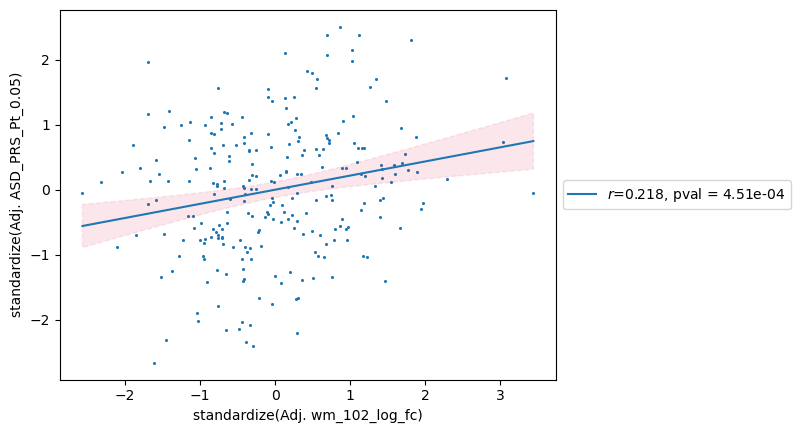

In [68]:
visualisation.SimplePlots.Scatter(x='wm_102_log_fc',
                                 y='ASD_PRS_Pt_0.05',
                                 data=df,
                                 adjust_covar={'x':['GA','PMA','sex','TBV'],'y':ancestry})

# SCZ Gene ontology PCA

In [63]:
df_IDs = pd.read_csv('../../codes/FBA/output_ASD/tractography/fba/SCZ_GO_0/stats_fdc/id_file_SCZ_PRSET.txt',header=None,names=['ID/Ses'])
df_IDs['ID/Ses'] = df_IDs['ID/Ses'].apply(lambda x: x.replace('.mif','').replace('_','/'))

In [64]:
df_covariates = pd.read_csv('../../codes/FBA/output_ASD/tractography/fba/SCZ_GO_0/stats_fdc/SCZ_GO_0_design.txt',delim_whitespace=' ')

In [65]:
df = pd.read_csv('df_euro_fba.csv')

In [68]:
combined_test = pd.merge(pd.concat([df_IDs,df_covariates],axis=1)[['ID/Ses']+[i for i in df_covariates.columns if 'SCZ' in i]],df,on='ID/Ses')

In [75]:
ancestry = [f'euro_Anc_PC{i}' for i in range(1,4)]

In [85]:
SCZ_GO_res = stats.MassUnivariate.mass_univariate(
    df=combined_test,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['SCZ_GO_0','GA','PMA']+[f'euro_Anc_PC{i}' for i in range(1,4)],
    dependentVar_cols=[i for i in combined_test.columns if 'wm_' in i and re.match(r'wm_\d+_fd$',i)]
)

,ID/Ses,SCZ_GO_0,SCZ_GO_1,SCZ_GO_2,SCZ_GO_3,SCZ_GO_4,SCZ_GO_5,SCZ_GO_6,ID,Session,...,wm_138_fdc,wm_139_fdc,wm_140_fdc,wm_141_fdc,wm_142_fdc,wm_143_fdc,wm_144_fdc,wm_145_fdc,wm_146_fdc,wm_147_fdc
0,sub-CC00818XX18/ses-4020,1.074851,-0.534756,-1.152666,-0.435882,-0.056858,-0.007309,-1.015391,CC00818XX18,4020,...,0.305105,0.342600,0.342350,0.334478,0.329024,0.369633,0.323525,0.319856,0.301943,0.493787
1,sub-CC00815XX15/ses-4120,0.519020,-1.135842,-0.848401,0.862962,-0.980124,-0.513738,-0.938148,CC00815XX15,4120,...,0.261030,0.302030,0.356407,0.304979,0.281297,0.451526,0.362997,0.336181,0.340297,0.465039
2,sub-CC00766XX16/ses-4200,0.175757,-1.203154,-0.181101,0.437749,1.237862,-1.057181,0.929428,CC00766XX16,4200,...,0.284912,0.266030,0.350764,0.327163,0.307391,0.462238,0.350877,0.326738,0.302035,0.487141
3,sub-CC00765XX15/ses-8210,1.055948,0.202444,1.614593,0.096662,-0.188891,-0.140937,-0.773598,CC00765XX15,8210,...,0.285734,0.321173,0.371101,0.281401,0.280481,0.538949,0.403121,0.359332,0.336873,0.592529
4,sub-CC00865XX16/ses-12330,0.617066,-2.234222,-0.392328,-1.253097,-0.447607,0.900583,-0.997165,CC00865XX16,12330,...,0.312301,0.315417,0.341381,0.346883,0.329593,0.454487,0.315032,0.246806,0.269917,0.454218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,sub-CC00685XX18/ses-226100,-0.363494,1.098021,-0.427150,0.396012,-0.492994,0.758992,1.076956,CC00685XX18,226100,...,0.299070,0.360894,0.440113,0.337640,0.314873,0.505049,0.409433,0.381678,0.350750,0.550237
217,sub-CC00713XX12/ses-229000,1.773763,-0.848510,-0.703112,-1.284490,1.047954,2.244010,-0.074012,CC00713XX12,229000,...,0.318034,0.387216,0.452803,0.341230,0.326509,0.512381,0.383910,0.374039,0.329165,0.542032
218,sub-CC00740XX15/ses-238400,-0.268928,-0.684267,0.370356,0.310176,-0.848410,0.826467,0.486216,CC00740XX15,238400,...,0.321052,0.390302,0.431343,0.326693,0.324756,0.599747,0.435450,0.357807,0.322154,0.489184
219,sub-CC00777XX19/ses-239102,0.637056,0.609220,-0.830101,0.619034,2.122522,0.046643,0.668288,CC00777XX19,239102,...,0.262019,0.349326,0.430485,0.307302,0.286709,0.444016,0.364019,0.319414,0.276418,0.545987


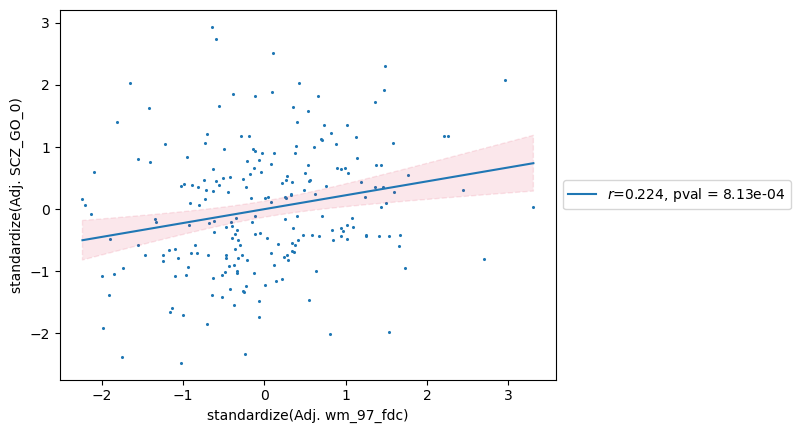

In [81]:
visualisation.SimplePlots.Scatter(x=['wm_97_fdc'],y='SCZ_GO_0',data=combined_test,
                                 adjust_covar={'x':['GA','PMA','TBV'],
                                               'y':ancestry})

In [79]:
stats.MultipleCorrection.matSpDLite(combined_test[[i for i in combined_test.columns if 'wm_' in i and re.match(r'wm_\d+_fdc$',i)]].corr())

Effective Number of Independent Variables [Veff] is 29.939981338156127
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 18.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0027777777777777757


18.000000000000014

In [105]:
mean_fc = pd.concat([pd.read_csv('../../codes/FBA/fc_id.txt',header=None,names=['FILE']),
pd.read_csv('../../codes/FBA/all_subj_fc_mean.txt',header=None,names=['mean_FC'])],axis=1)
mean_fc['FILE'] = mean_fc['FILE'].apply(lambda x: x.split('/')[-1].replace('.mif','').replace('_','/'))
mean_fd = pd.concat([pd.read_csv('../../codes/FBA/fd_id.txt',header=None,names=['FILE']),
pd.read_csv('../../codes/FBA/all_subj_fd_mean.txt',header=None,names=['mean_FD'])],axis=1)
mean_fd['FILE'] = mean_fd['FILE'].apply(lambda x: x.split('/')[-1].replace('.mif','').replace('_','/'))
mean_fdc = pd.concat([pd.read_csv('../../codes/FBA/fdc_id.txt',header=None,names=['FILE']),
pd.read_csv('../../codes/FBA/all_subj_fdc_mean.txt',header=None,names=['mean_FDC'])],axis=1)
mean_fdc['FILE'] = mean_fdc['FILE'].apply(lambda x: x.split('/')[-1].replace('.mif','').replace('_','/'))
mean_fba_values = mean_fc.merge(mean_fdc,on='FILE').merge(mean_fd,on='FILE')
mean_fba_values.rename(columns={'FILE':'ID/Ses'},inplace=True)

In [110]:
combined_test = combined_test.merge(mean_fba_values,on='ID/Ses')

In [ ]:
combined_test['AS']

In [119]:
SCZ_GO_res = stats.MassUnivariate.mass_univariate(
    df=combined_test,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['ASD_imputed_PRS_Pt_0.05','GA','PMA']+[f'euro_Anc_PC{i}' for i in range(1,4)],
    dependentVar_cols=[i for i in combined_test.columns if 'mean_' in i]
)

In [120]:
SCZ_GO_res[1]

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('ASD_imputed_PRS_Pt_0.05'))_coef,standardize(Q('ASD_imputed_PRS_Pt_0.05'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
mean_FC,1.056984,1.300441e-249,0.053485,1.081159e-12,-0.001488,0.675818,-0.016284,0.000360,0.077911,2.850675e-42,0.009339,0.009860,-0.003641,0.313008,0.000781,0.828495
mean_FDC,0.177465,5.470199e-235,0.003874,5.785429e-03,0.000116,0.868817,-0.001124,0.204866,0.015839,4.830682e-44,0.001462,0.039521,-0.001046,0.141332,0.000193,0.785266
mean_FD,0.169413,1.208438e-267,-0.004359,4.993245e-06,0.000287,0.540618,0.001471,0.013724,0.003227,1.632021e-07,-0.000050,0.915606,-0.000395,0.405614,0.000105,0.825874
